# TFG

9/5/2025

## Case Study: Solar Forecasting
1. Naive t-24
2. Prophet
3. XGB
4. GRU
5. LSTM

Using X1...X24 and (W+1...W+24)B

## Libraries

In [ ]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import seaborn as sns
import random
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from xgboost import XGBRegressor
from sklearn.multioutput import MultiOutputRegressor
from datetime import timedelta

# models
from prophet import Prophet
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, GRU, Dense, InputLayer
from feature_engine.timeseries.forecasting import WindowFeatures
from skforecast.preprocessing import RollingFeatures
from skforecast.recursive import ForecasterEquivalentDate, ForecasterRecursive
from skforecast.model_selection import TimeSeriesFold, backtesting_forecaster
from sktime.forecasting.naive import NaiveForecaster

# functions
from utils.preprocess import *
from models.cnn_gru_model import build_cnn_gru_model, fit_cnn_gru_model, build_lstm
from models.prophet_model import train_prophet, forecast_prophet
from utils.evaluation import evaluate, evaluate_plot


c:\Users\melan\Documents\U\Clases\Cuarto\TFG\tfg-final\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


## Load Data

In [2]:
df = pd.read_csv('data/final_unified_dataset.csv')
df_solar = preprocess_solar(df)
target='solar'

In [3]:
lag_features = [col for col in df_solar.columns if 'solar_power_' in col]
time_features = ['year', 'month', 'hour', 'hour_sin', 'hour_cos', 'month_sin', 'month_cos']
weather_features = [col for col in df_solar.columns if col not in lag_features + time_features + ['region', 'region_code', 'solar']]

In [4]:
chosen_regions = ['Nouvelle-Aquitaine', 'Hauts-de-France']
regions = df_solar['region'].unique()
print(regions)

region_dfs = {}

for region in regions:
    region_data = df_solar[df_solar['region'] == region]
    train, val, test = split_data_val(region_data)
    energy_train, weather_train = divide_energy_weather(train, 'solar')
    energy_val, weather_val = divide_energy_weather(val, 'solar')
    energy_test, weather_test = divide_energy_weather(test, 'solar')
    region_data = region_data.drop(columns=['region'])
    region_dfs[region] = {
        'region_data': region_data.asfreq('h'),
        'train-test': (train, test),
        'energy_train': energy_train.asfreq('h'),
        'weather_train': weather_train.asfreq('h'),
        'energy_val': energy_val.asfreq('h'),
        'weather_val': weather_val.asfreq('h'),
        'energy_test': energy_test.asfreq('h'),
        'weather_test': weather_test.asfreq('h')
    }

['Auvergne-Rhône-Alpes' 'Bourgogne-Franche-Comté' 'Pays-de-la-Loire'
 'Bretagne' 'Centre-Val de Loire' 'Grand-Est' 'Hauts-de-France'
 'Ile-de-France' 'Normandie' 'Nouvelle-Aquitaine' 'Occitanie' 'PACA']
Train shape: (30648, 20), train period: 2018-01-01 00:00:00 to 2021-06-30 23:00:00
Validation shape: (4416, 20), validation period: 2021-07-01 00:00:00 to 2021-12-31 23:00:00
Test shape: (8760, 20), test period: 2022-01-01 00:00:00 to 2022-12-31 23:00:00
Train shape: (30648, 20), train period: 2018-01-01 00:00:00 to 2021-06-30 23:00:00
Validation shape: (4416, 20), validation period: 2021-07-01 00:00:00 to 2021-12-31 23:00:00
Test shape: (8760, 20), test period: 2022-01-01 00:00:00 to 2022-12-31 23:00:00
Train shape: (30648, 20), train period: 2018-01-01 00:00:00 to 2021-06-30 23:00:00
Validation shape: (4416, 20), validation period: 2021-07-01 00:00:00 to 2021-12-31 23:00:00
Test shape: (8760, 20), test period: 2022-01-01 00:00:00 to 2022-12-31 23:00:00
Train shape: (30648, 20), train 

In [5]:
weather_train.columns

Index(['total_radiation', 'relative_humidity_2m', 'is_day', 'surface_pressure',
       'cloud_cover', 'sunshine_duration'],
      dtype='object')

## Modeling
### Naive

In [6]:
naive_results = {}
for region, region_data in region_dfs.items():
    print(f'Naive forecast for {region}')
    y_true = region_data['energy_test'][24:].copy()
    y_pred_naive = region_data['energy_test'].shift(24).dropna()
    
    eval_naive = evaluate(y_true, y_pred_naive, 'Naive')

    naive_results[region] = {
        'y_true': y_true,
        'y_pred_naive': y_pred_naive,
        'mae': eval_naive['MAE'],
        'rmse': eval_naive['RMSE'],
        'nrmse': eval_naive['NRMSE']
    }
    #evaluate_plot(y_true, y_pred_naive, 'Naive', region)


Naive forecast for Auvergne-Rhône-Alpes
Naive	MAE: 54.103136446886445, RMSE: 117.42497068699865, NRMSE: 0.5039173473113033
Naive forecast for Bourgogne-Franche-Comté
Naive	MAE: 21.50297619047619, RMSE: 47.518345213907985, NRMSE: 0.6159451890273335
Naive forecast for Pays-de-la-Loire
Naive	MAE: 31.923363095238095, RMSE: 68.98407309581161, NRMSE: 0.615616518220433
Naive forecast for Bretagne
Naive	MAE: 12.834363553113553, RMSE: 27.807654072215442, NRMSE: 0.639465915859855
Naive forecast for Centre-Val de Loire
Naive	MAE: 30.131639194139193, RMSE: 66.74657484935747, NRMSE: 0.6366436267559202
Naive forecast for Grand-Est
Naive	MAE: 40.12162316849817, RMSE: 87.77269434965201, NRMSE: 0.623364480197322
Naive forecast for Hauts-de-France
Naive	MAE: 17.209478021978022, RMSE: 37.740603286737304, NRMSE: 0.7154523583814794
Naive forecast for Ile-de-France
Naive	MAE: 8.148294413919414, RMSE: 17.715770631702465, NRMSE: 0.7408106352335793
Naive forecast for Normandie
Naive	MAE: 10.164720695970695, RM

### Prophet

In [7]:
# # Prophet without exogenous variables
# for region, region_data in region_dfs.items():
#     print(f"Prophet forecast for {region}")
#     train_data, test_data = region_data['train-test']
#     train_df = train_data.reset_index().rename(columns={'datetime': 'ds', 'solar':'y'})
#     prophet_noX = Prophet(daily_seasonality=True, yearly_seasonality=True)
#     prophet_noX.fit(train_df)

#     future= prophet_noX.make_future_dataframe(periods=365)
#     forecast = prophet_noX.predict(future)

#     forecast = forecast[forecast['ds'] > train_df['ds'].max()]

#     #fig = prophet_noX.plot(forecast)
#     #plt.title(f'{region} Solar Energy Forecast - Prophet\n(without exogenous variables)')

In [8]:
# Prophet with exogenous variables
random.seed(100457522)
prophet_results = {}
for region, region_data in region_dfs.items():
    print(f"Prophet X for {region}")
    energy_train = region_data['energy_train']
    weather_train = region_data['weather_train']
    energy_test = region_data['energy_test']
    weather_test = region_data['weather_test']

    shifted_weather_train = weather_train.shift(-24).dropna() # W+1
    # add noise to weather data
    shifted_weather_train = add_weather_error(shifted_weather_train)
    max_idx = shifted_weather_train.index.max()
    energy_train = energy_train.loc[:max_idx]

    shifted_weather_test = weather_test.shift(-24).dropna() # W+1
    # add noise to weather test
    shifted_weather_test = add_weather_error(shifted_weather_test)
    max_idx = shifted_weather_test.index.max()
    energy_test = energy_test.shift(-24).dropna() # E+1

    prophet_df = pd.concat([energy_train, shifted_weather_train], axis=1)
    prophet_test_df = pd.concat([energy_test, shifted_weather_test], axis=1)
    prophet_model = train_prophet(prophet_df, 'solar') 
    #y_pred_prophet = forecast_prophet(prophet_model, prophet_test_df, 'solar', region)
    
    predictions = []

    for day in pd.date_range(start='2022-01-01', end='2022-12-30', freq='D'):
        future_window = pd.date_range(start=day, periods=24, freq='h')
        
        df_future = pd.DataFrame({'ds': future_window})
        
        df_future = df_future.set_index('ds').join(weather_test).reset_index()

        forecast = prophet_model.predict(df_future)
        pred = np.maximum(forecast['yhat'].values, 0) # set negatives to 0 
        #pred = forecast['yhat'].values
        predictions.append(pred)
    
    y_pred_prophet = np.stack(predictions).flatten()

    eval_prophet = evaluate(energy_test, y_pred_prophet, 'Prophet')
    #evaluate_plot(energy_test, y_pred_prophet, 'Prophet', region)

    prophet_results[region] = {
        'y_true': energy_test,
        'y_pred_prophet': y_pred_prophet,
        'mae': eval_prophet['MAE'], 
        'rmse': eval_prophet['RMSE'],
        'nrmse': eval_prophet['NRMSE']
    }

Prophet X for Auvergne-Rhône-Alpes


17:40:09 - cmdstanpy - INFO - Chain [1] start processing
17:40:16 - cmdstanpy - INFO - Chain [1] done processing


Prophet	MAE: 133.58236298995098, RMSE: 171.523867109553, NRMSE: 0.7360772722253058
Prophet X for Bourgogne-Franche-Comté


17:40:26 - cmdstanpy - INFO - Chain [1] start processing
17:40:33 - cmdstanpy - INFO - Chain [1] done processing


Prophet	MAE: 46.3512400657171, RMSE: 70.27157016307304, NRMSE: 0.9108784275314594
Prophet X for Pays-de-la-Loire


17:40:43 - cmdstanpy - INFO - Chain [1] start processing
17:40:49 - cmdstanpy - INFO - Chain [1] done processing


Prophet	MAE: 67.12998098655672, RMSE: 86.51168078474448, NRMSE: 0.7720335625316319
Prophet X for Bretagne


17:41:00 - cmdstanpy - INFO - Chain [1] start processing
17:41:04 - cmdstanpy - INFO - Chain [1] done processing


Prophet	MAE: 21.364105109325745, RMSE: 34.089236057223424, NRMSE: 0.7839174243064239
Prophet X for Centre-Val de Loire


17:41:14 - cmdstanpy - INFO - Chain [1] start processing
17:41:21 - cmdstanpy - INFO - Chain [1] done processing


Prophet	MAE: 97.79753936981881, RMSE: 112.08299480228409, NRMSE: 1.0690724500791071
Prophet X for Grand-Est


17:41:32 - cmdstanpy - INFO - Chain [1] start processing
17:41:43 - cmdstanpy - INFO - Chain [1] done processing


Prophet	MAE: 106.29107412671841, RMSE: 122.09580216451639, NRMSE: 0.8671282887519172
Prophet X for Hauts-de-France


17:41:53 - cmdstanpy - INFO - Chain [1] start processing
17:42:06 - cmdstanpy - INFO - Chain [1] done processing


Prophet	MAE: 55.12933749980587, RMSE: 61.5540456748055, NRMSE: 1.1668861467680074
Prophet X for Ile-de-France


17:42:16 - cmdstanpy - INFO - Chain [1] start processing
17:42:24 - cmdstanpy - INFO - Chain [1] done processing


Prophet	MAE: 18.594232487609442, RMSE: 22.56716059370989, NRMSE: 0.9436785405726288
Prophet X for Normandie


17:42:34 - cmdstanpy - INFO - Chain [1] start processing
17:42:40 - cmdstanpy - INFO - Chain [1] done processing


Prophet	MAE: 21.32871097318354, RMSE: 25.75932829002274, NRMSE: 0.838861822525637
Prophet X for Nouvelle-Aquitaine


17:42:50 - cmdstanpy - INFO - Chain [1] start processing
17:42:57 - cmdstanpy - INFO - Chain [1] done processing


Prophet	MAE: 269.9893064003403, RMSE: 359.4568061901212, NRMSE: 0.6689866543893068
Prophet X for Occitanie


17:43:07 - cmdstanpy - INFO - Chain [1] start processing
17:43:11 - cmdstanpy - INFO - Chain [1] done processing


Prophet	MAE: 213.1726241911894, RMSE: 284.5731443420896, NRMSE: 0.6582219700085122
Prophet X for PACA


17:43:21 - cmdstanpy - INFO - Chain [1] start processing
17:43:28 - cmdstanpy - INFO - Chain [1] done processing


Prophet	MAE: 124.26780299628886, RMSE: 186.98811034168435, NRMSE: 0.630674917463489


In [9]:
# # Evaluate prophet
# for region, results in prophet_results.items():
#     y_true = results['y_true']
#     y_pred = results['y_pred_prophet']
#     evaluate(y_true, y_pred, 'prophet')
#     evaluate_plot(y_true, y_pred, 'prophet', region)

### XGBoost

In [10]:
random.seed(100457522)
xgboost_results = {}

for region, region_data in region_dfs.items():
    print(f"Forecasting for {region}")
    energy_train = region_data['energy_train']
    weather_train = region_data['weather_train']
    energy_test = region_data['energy_test']
    weather_test = region_data['weather_test']

    weather_train = add_weather_error(weather_train)
    weather_test = add_weather_error(weather_test)

    X_energy_train, X_weather_train, y_train = create_daily_blocks(energy_train, weather_train)
    X_energy_test, X_weather_test, y_test = create_daily_blocks(energy_test, weather_test)

    X_weather_flat = X_weather_train.reshape(X_weather_train.shape[0], -1)
    X_weather_flat_test = X_weather_test.reshape(X_weather_test.shape[0], -1)

    X_train = np.hstack([X_energy_train, X_weather_flat])
    X_test = np.hstack([X_energy_test, X_weather_flat_test])

    xgb_model = XGBRegressor(
        n_estimators=100,
        max_depth=6,
        learning_rate=0.05,
        random_state=42
    )

    multi_output_model = MultiOutputRegressor(xgb_model)
    multi_output_model.fit(X_train, y_train)

    y_pred_xgb = multi_output_model.predict(X_test).flatten() # (364, 24)
    y_pred_xgb = np.maximum(y_pred_xgb, 0) # set negatives to zero

    y_true = pd.Series(y_test.flatten(), index= energy_test.index[24:])

    eval_xgb = evaluate(y_true, y_pred_xgb, 'XGB')
    #evaluate_plot(y_true, y_pred_xgb, 'XGB', region)

    xgboost_results[region] = {
        'y_true': y_true,
        'y_pred_xgb': y_pred_xgb,
        'mae': eval_xgb['MAE'],
        'rmse': eval_xgb['RMSE'],
        'nrmse': eval_xgb['NRMSE']
    }

Forecasting for Auvergne-Rhône-Alpes
XGB	MAE: 73.00899176368266, RMSE: 134.58130835649547, NRMSE: 0.5775420296715353
Forecasting for Bourgogne-Franche-Comté
XGB	MAE: 31.4266847062067, RMSE: 59.113159992480476, NRMSE: 0.7662402034764995
Forecasting for Pays-de-la-Loire
XGB	MAE: 33.852184654907845, RMSE: 64.74347512035895, NRMSE: 0.5777732589916693
Forecasting for Bretagne
XGB	MAE: 13.74634691089871, RMSE: 26.719209213881612, NRMSE: 0.6144359947313108
Forecasting for Centre-Val de Loire
XGB	MAE: 41.32284170110375, RMSE: 79.0544318762039, NRMSE: 0.7540386953845284
Forecasting for Grand-Est
XGB	MAE: 32.26242673306365, RMSE: 63.826829504848085, NRMSE: 0.4533001828385876
Forecasting for Hauts-de-France
XGB	MAE: 23.058470903379774, RMSE: 43.97527829038644, NRMSE: 0.833643710576169
Forecasting for Ile-de-France
XGB	MAE: 8.450115972838988, RMSE: 16.58988292910979, NRMSE: 0.6937300085140854
Forecasting for Normandie
XGB	MAE: 8.376986092195608, RMSE: 16.78608817790261, NRMSE: 0.5466450197556375
F

In [11]:
# for region, region_results in xgboost_results.items():
#     y_true = region_results['y_true']
#     y_pred_xgb = region_results['y_pred_xgb']
#     evaluate(y_true, y_pred_xgb, 'XGB')
#     evaluate_plot(y_true, y_pred_xgb, 'XGB', region, 'solar')


### CNN-GRU

Forecasting for Auvergne-Rhône-Alpes
Epoch 1/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.1505 - mse: 0.0589 - val_loss: 0.1005 - val_mse: 0.0309
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0909 - mse: 0.0185 - val_loss: 0.0863 - val_mse: 0.0224
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0749 - mse: 0.0124 - val_loss: 0.0707 - val_mse: 0.0158
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0628 - mse: 0.0094 - val_loss: 0.0755 - val_mse: 0.0176
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0584 - mse: 0.0086 - val_loss: 0.0586 - val_mse: 0.0109
Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0531 - mse: 0.0074 - val_loss: 0.0667 - val_mse: 0.0147
Epoch 7/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0488 - mse: 0.0066 - val_loss: 0.0546 - val_mse: 0.0097
Epoch 8/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0477 - mse: 0.0066 - val_loss: 0.0607 - val_mse: 0.0123
Epoch 9/50
40/40 ━━━━━━━━━━

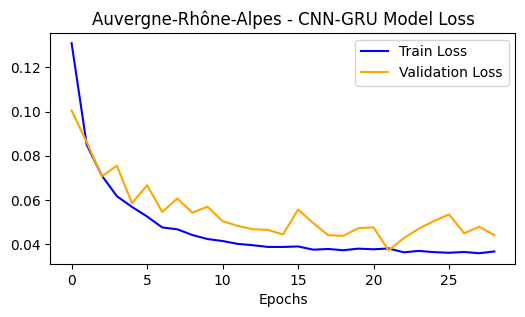

Forecasting for Bourgogne-Franche-Comté
Epoch 1/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.1577 - mse: 0.0734 - val_loss: 0.1405 - val_mse: 0.0673
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.1122 - mse: 0.0316 - val_loss: 0.0894 - val_mse: 0.0280
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0813 - mse: 0.0165 - val_loss: 0.0821 - val_mse: 0.0232
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0676 - mse: 0.0116 - val_loss: 0.0735 - val_mse: 0.0193
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0636 - mse: 0.0111 - val_loss: 0.0660 - val_mse: 0.0157
Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0568 - mse: 0.0094 - val_loss: 0.0638 - val_mse: 0.0150
Epoch 7/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0534 - mse: 0.0086 - val_loss: 0.0759 - val_mse: 0.0218
Epoch 8/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0495 - mse: 0.0078 - val_loss: 0.0689 - val_mse: 0.0184
Epoch 9/50
40/40 ━━━━━━━

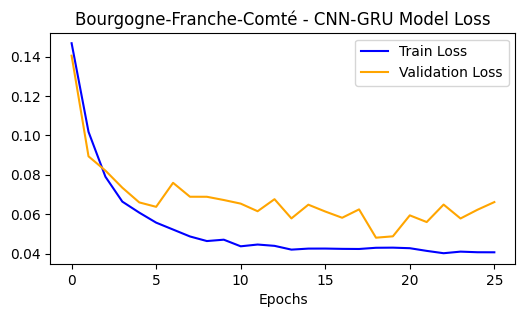

Forecasting for Pays-de-la-Loire
Epoch 1/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.1577 - mse: 0.0666 - val_loss: 0.1298 - val_mse: 0.0518
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1039 - mse: 0.0287 - val_loss: 0.0869 - val_mse: 0.0255
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0819 - mse: 0.0167 - val_loss: 0.0776 - val_mse: 0.0191
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0683 - mse: 0.0112 - val_loss: 0.0735 - val_mse: 0.0175
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0587 - mse: 0.0088 - val_loss: 0.0583 - val_mse: 0.0106
Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0538 - mse: 0.0071 - val_loss: 0.0604 - val_mse: 0.0125
Epoch 7/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0498 - mse: 0.0069 - val_loss: 0.0610 - val_mse: 0.0124
Epoch 8/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0480 - mse: 0.0066 - val_loss: 0.0568 - val_mse: 0.0108
Epoch 9/50
40/40 ━━━━━━━━━━━━━━

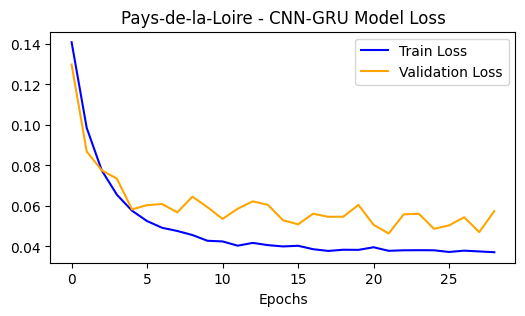

Forecasting for Bretagne
Epoch 1/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.1662 - mse: 0.0827 - val_loss: 0.1688 - val_mse: 0.0958
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.1403 - mse: 0.0669 - val_loss: 0.1567 - val_mse: 0.0844
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.1287 - mse: 0.0574 - val_loss: 0.1463 - val_mse: 0.0747
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.1181 - mse: 0.0493 - val_loss: 0.1377 - val_mse: 0.0666
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.1144 - mse: 0.0451 - val_loss: 0.1302 - val_mse: 0.0596
Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.1069 - mse: 0.0393 - val_loss: 0.1240 - val_mse: 0.0536
Epoch 7/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.1033 - mse: 0.0356 - val_loss: 0.1185 - val_mse: 0.0487
Epoch 8/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0992 - mse: 0.0327 - val_loss: 0.1139 - val_mse: 0.0446
Epoch 9/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1

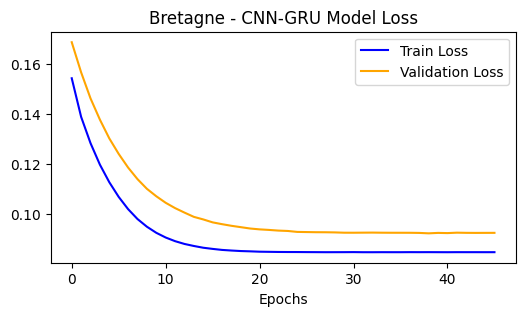

Forecasting for Centre-Val de Loire
Epoch 1/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 0.1232 - mse: 0.0410 - val_loss: 0.1449 - val_mse: 0.0682
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0878 - mse: 0.0229 - val_loss: 0.1052 - val_mse: 0.0376
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0632 - mse: 0.0136 - val_loss: 0.0974 - val_mse: 0.0322
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0564 - mse: 0.0120 - val_loss: 0.0883 - val_mse: 0.0268
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0495 - mse: 0.0093 - val_loss: 0.0816 - val_mse: 0.0234
Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0483 - mse: 0.0093 - val_loss: 0.0813 - val_mse: 0.0236
Epoch 7/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0448 - mse: 0.0082 - val_loss: 0.0769 - val_mse: 0.0213
Epoch 8/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0472 - mse: 0.0090 - val_loss: 0.0764 - val_mse: 0.0211
Epoch 9/50
40/40 ━━━━━━━━━━━

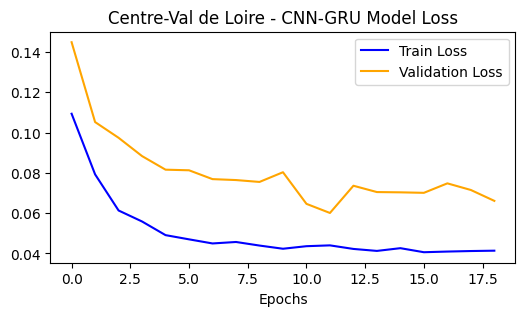

Forecasting for Grand-Est
Epoch 1/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - loss: 0.1070 - mse: 0.0328 - val_loss: 0.0747 - val_mse: 0.0209
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0760 - mse: 0.0177 - val_loss: 0.0551 - val_mse: 0.0111
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0609 - mse: 0.0110 - val_loss: 0.0460 - val_mse: 0.0076
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0531 - mse: 0.0084 - val_loss: 0.0416 - val_mse: 0.0059
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0462 - mse: 0.0068 - val_loss: 0.0319 - val_mse: 0.0033
Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0411 - mse: 0.0053 - val_loss: 0.0355 - val_mse: 0.0042
Epoch 7/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0398 - mse: 0.0054 - val_loss: 0.0356 - val_mse: 0.0044
Epoch 8/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0374 - mse: 0.0048 - val_loss: 0.0332 - val_mse: 0.0037
Epoch 9/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 

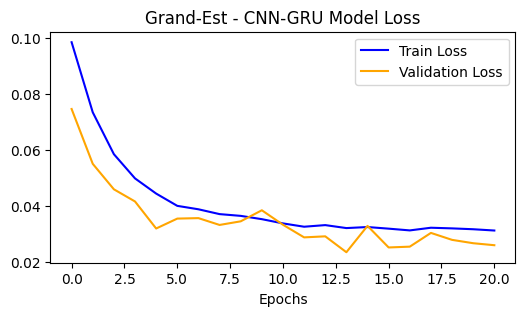

Forecasting for Hauts-de-France
Epoch 1/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 0.0978 - mse: 0.0255 - val_loss: 0.1297 - val_mse: 0.0592
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0649 - mse: 0.0116 - val_loss: 0.1037 - val_mse: 0.0394
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0503 - mse: 0.0069 - val_loss: 0.0932 - val_mse: 0.0324
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0442 - mse: 0.0051 - val_loss: 0.0804 - val_mse: 0.0251
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0407 - mse: 0.0044 - val_loss: 0.0824 - val_mse: 0.0268
Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0373 - mse: 0.0041 - val_loss: 0.0761 - val_mse: 0.0228
Epoch 7/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0372 - mse: 0.0042 - val_loss: 0.0690 - val_mse: 0.0193
Epoch 8/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0356 - mse: 0.0038 - val_loss: 0.0727 - val_mse: 0.0214
Epoch 9/50
40/40 ━━━━━━━━━━━━━━━

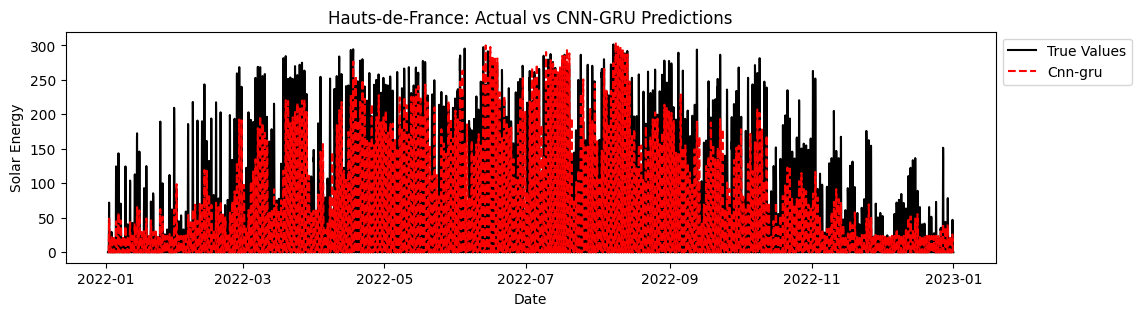

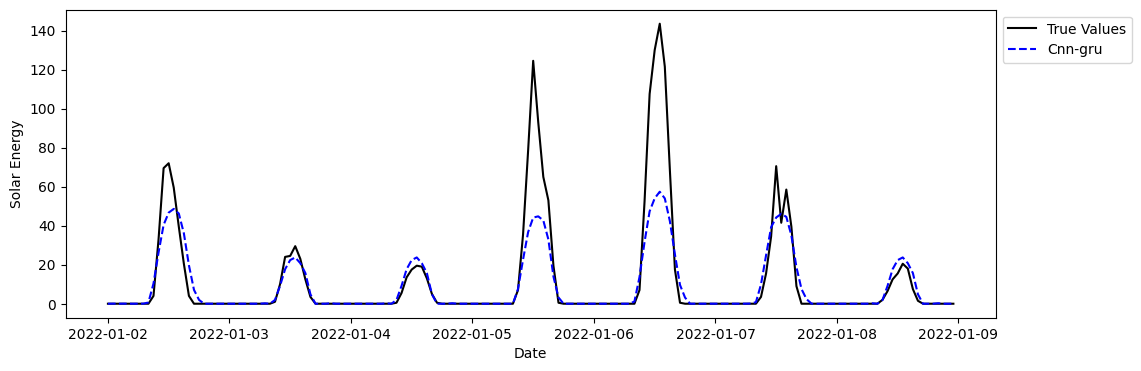

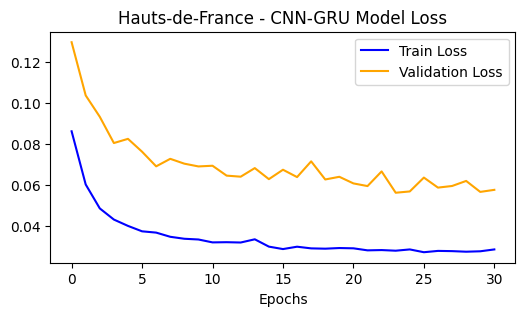

Forecasting for Ile-de-France
Epoch 1/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 0.1220 - mse: 0.0446 - val_loss: 0.1393 - val_mse: 0.0642
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0900 - mse: 0.0242 - val_loss: 0.1141 - val_mse: 0.0446
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0726 - mse: 0.0153 - val_loss: 0.0902 - val_mse: 0.0276
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0595 - mse: 0.0113 - val_loss: 0.0747 - val_mse: 0.0204
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0534 - mse: 0.0093 - val_loss: 0.0825 - val_mse: 0.0252
Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0497 - mse: 0.0085 - val_loss: 0.0685 - val_mse: 0.0177
Epoch 7/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0485 - mse: 0.0081 - val_loss: 0.0754 - val_mse: 0.0213
Epoch 8/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0470 - mse: 0.0078 - val_loss: 0.0680 - val_mse: 0.0176
Epoch 9/50
40/40 ━━━━━━━━━━━━━━━━━

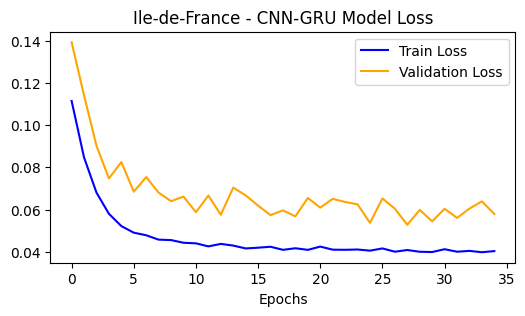

Forecasting for Normandie
Epoch 1/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 0.1461 - mse: 0.0632 - val_loss: 0.1369 - val_mse: 0.0638
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1151 - mse: 0.0393 - val_loss: 0.0942 - val_mse: 0.0316
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0843 - mse: 0.0200 - val_loss: 0.0778 - val_mse: 0.0224
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0697 - mse: 0.0145 - val_loss: 0.0658 - val_mse: 0.0162
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0603 - mse: 0.0109 - val_loss: 0.0597 - val_mse: 0.0133
Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0544 - mse: 0.0090 - val_loss: 0.0646 - val_mse: 0.0153
Epoch 7/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0516 - mse: 0.0084 - val_loss: 0.0592 - val_mse: 0.0129
Epoch 8/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0486 - mse: 0.0077 - val_loss: 0.0549 - val_mse: 0.0112
Epoch 9/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 

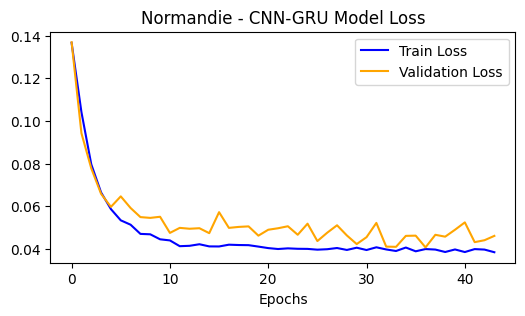

Forecasting for Nouvelle-Aquitaine
Epoch 1/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 0.1659 - mse: 0.0730 - val_loss: 0.1221 - val_mse: 0.0409
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.1167 - mse: 0.0336 - val_loss: 0.0871 - val_mse: 0.0230
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0840 - mse: 0.0178 - val_loss: 0.0794 - val_mse: 0.0188
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0735 - mse: 0.0143 - val_loss: 0.0708 - val_mse: 0.0159
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0637 - mse: 0.0111 - val_loss: 0.0546 - val_mse: 0.0095
Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0557 - mse: 0.0090 - val_loss: 0.0579 - val_mse: 0.0108
Epoch 7/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0522 - mse: 0.0083 - val_loss: 0.0576 - val_mse: 0.0110
Epoch 8/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0489 - mse: 0.0074 - val_loss: 0.0542 - val_mse: 0.0098
Epoch 9/50
40/40 ━━━━━━━━━━━━

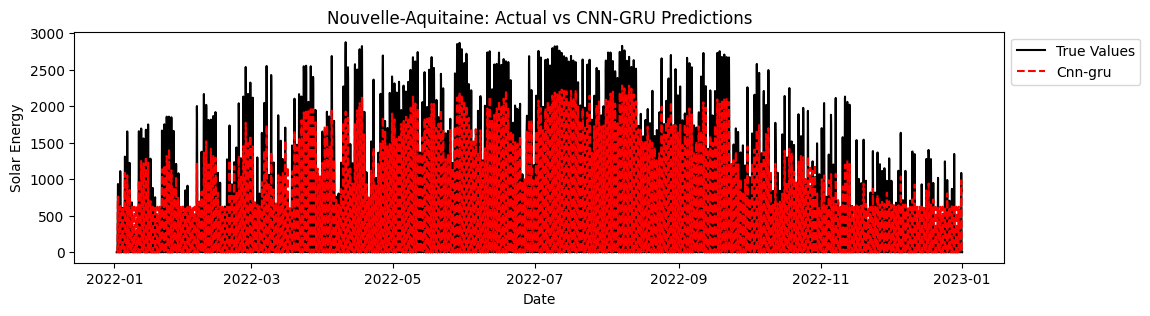

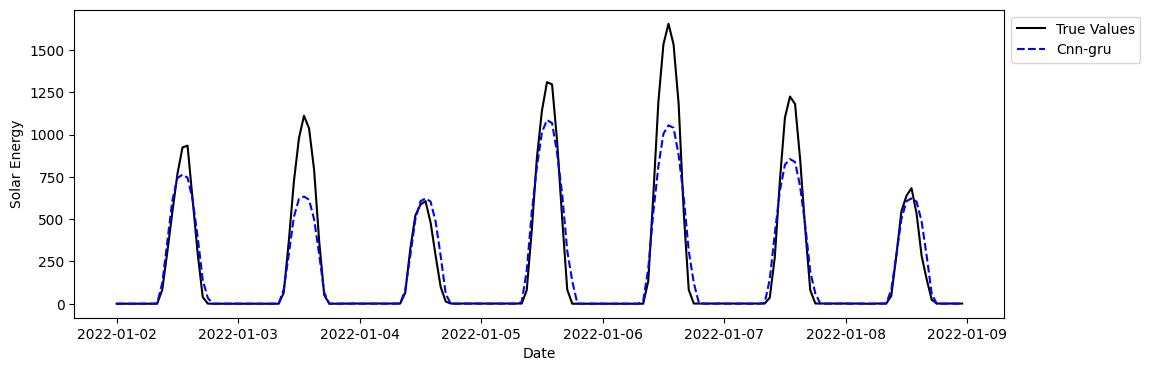

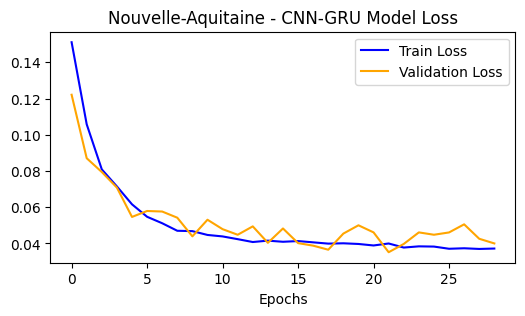

Forecasting for Occitanie
Epoch 1/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.1617 - mse: 0.0700 - val_loss: 0.1209 - val_mse: 0.0471
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1069 - mse: 0.0279 - val_loss: 0.0836 - val_mse: 0.0229
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0839 - mse: 0.0168 - val_loss: 0.0811 - val_mse: 0.0202
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0711 - mse: 0.0122 - val_loss: 0.0697 - val_mse: 0.0151
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0627 - mse: 0.0100 - val_loss: 0.0566 - val_mse: 0.0097
Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0548 - mse: 0.0078 - val_loss: 0.0599 - val_mse: 0.0110
Epoch 7/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0512 - mse: 0.0075 - val_loss: 0.0647 - val_mse: 0.0131
Epoch 8/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0488 - mse: 0.0075 - val_loss: 0.0745 - val_mse: 0.0175
Epoch 9/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 

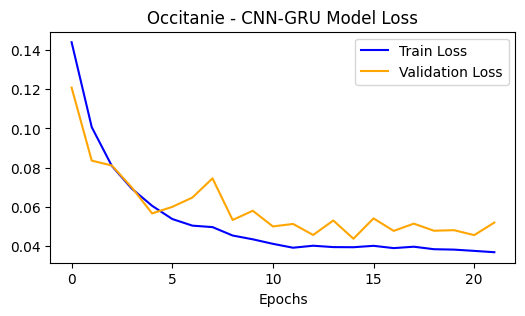

Forecasting for PACA
Epoch 1/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 0.1772 - mse: 0.0835 - val_loss: 0.1129 - val_mse: 0.0384
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.1220 - mse: 0.0345 - val_loss: 0.0829 - val_mse: 0.0212
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0934 - mse: 0.0209 - val_loss: 0.0761 - val_mse: 0.0171
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0794 - mse: 0.0153 - val_loss: 0.0681 - val_mse: 0.0138
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0716 - mse: 0.0128 - val_loss: 0.0760 - val_mse: 0.0171
Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0644 - mse: 0.0109 - val_loss: 0.0568 - val_mse: 0.0096
Epoch 7/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0580 - mse: 0.0093 - val_loss: 0.0529 - val_mse: 0.0083
Epoch 8/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0552 - mse: 0.0090 - val_loss: 0.0477 - val_mse: 0.0070
Epoch 9/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 15

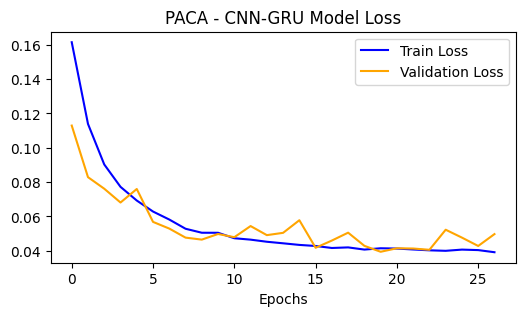

In [12]:
random.seed(100457522)

cnn_gru_results = {}
input_width = 24
forecast_horizon=24

for region, region_data in region_dfs.items():
    print(f"Forecasting for {region}")
    energy_train = region_data['energy_train']
    weather_train = region_data['weather_train']
    energy_val = region_data['energy_val']
    weather_val = region_data['weather_val']
    energy_test = region_data['energy_test']
    weather_test = region_data['weather_test']

    # add 1% of error to future weather data
    weather_train = add_weather_error(weather_train)
    weather_val = add_weather_error(weather_val)
    weather_test = add_weather_error(weather_test)

    # create sequences
    X_energy_train, X_weather_train, y_train = create_daily_blocks(energy_train, weather_train)
    X_energy_val, X_weather_val, y_val = create_daily_blocks(energy_val, weather_val)
    X_energy_test, X_weather_test, y_test = create_daily_blocks(energy_test, weather_test)

    # reshape energy to 3D (N, 24, 1)
    X_energy_train_3D = X_energy_train[..., np.newaxis]  # shape (N, 24, 1)
    X_energy_val_3D = X_energy_val[..., np.newaxis]
    X_energy_test_3D  = X_energy_test[..., np.newaxis]

    # join energy and weather
    X_train_combined = np.concatenate([X_energy_train_3D, X_weather_train], axis=-1)
    X_val_combined = np.concatenate([X_energy_val_3D, X_weather_val], axis=-1)
    X_test_combined  = np.concatenate([X_energy_test_3D, X_weather_test], axis=-1)

    # flatten to scale (shapes not matching)
    X_train_flat = X_train_combined.reshape(-1, X_train_combined.shape[-1])
    X_val_flat = X_val_combined.reshape(-1, X_val_combined.shape[-1])
    X_test_flat  = X_test_combined.reshape(-1, X_test_combined.shape[-1])

    # scale the data
    scaler_X = MinMaxScaler()
    X_train_scaled_flat = scaler_X.fit_transform(X_train_flat)
    X_val_scaled_flat = scaler_X.transform(X_val_flat)
    X_test_scaled_flat  = scaler_X.transform(X_test_flat)

    # Reshape back to original 
    X_train_scaled = X_train_scaled_flat.reshape(X_train_combined.shape)
    X_val_scaled = X_val_scaled_flat.reshape(X_val_combined.shape)
    X_test_scaled  = X_test_scaled_flat.reshape(X_test_combined.shape)

    scaler_y = MinMaxScaler()
    y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).reshape(y_train.shape)
    y_val_scaled = scaler_y.transform(y_val.reshape(-1,1)).reshape(y_val.shape)
    y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).reshape(y_test.shape)

    # fit cnn gru model
    input_shape = X_train_scaled.shape[1:]
    cnn_gru_model = build_cnn_gru_model(input_shape, forecast_horizon)
    history = fit_cnn_gru_model(cnn_gru_model, 
                                X_train_scaled, y_train_scaled,
                                X_val_scaled, y_val_scaled)
    history_mse = history

    # predict
    y_pred_cnn_gru = cnn_gru_model.predict(X_test_scaled)
    y_pred_cnn_gru = scaler_y.inverse_transform(y_pred_cnn_gru).flatten()
    y_pred_cnn_gru = np.maximum(y_pred_cnn_gru, 0) # set negatives to 0

    y_true = pd.Series(y_test.flatten(), index=energy_test.index[24:])

    eval_cnn_gru = evaluate(y_true, y_pred_cnn_gru, 'CNN GRU')
    if region in chosen_regions:
        evaluate_plot(y_true, y_pred_cnn_gru, 'CNN-GRU', region)

    cnn_gru_results[region] = {
        'y_true': y_true,
        'y_pred_cnn_gru': y_pred_cnn_gru,
        'mae': eval_cnn_gru['MAE'],
        'rmse': eval_cnn_gru['RMSE'],
        'nrmse': eval_cnn_gru['NRMSE']
    }

    #Plot loss and val loss
    plt.figure(figsize=(6, 3))
    plt.plot(history.history['loss'], label='Train Loss', color='blue')
    plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
    plt.xlabel('Epochs')
    plt.title(f'{region} - CNN-GRU Model Loss')
    plt.legend()
    plt.show()

### LSTM

Forecasting for Auvergne-Rhône-Alpes
Epoch 1/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 0.1261 - mse: 0.0525 - val_loss: 0.0602 - val_mse: 0.0117
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0460 - mse: 0.0053 - val_loss: 0.0481 - val_mse: 0.0066
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0357 - mse: 0.0033 - val_loss: 0.0530 - val_mse: 0.0089
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0329 - mse: 0.0029 - val_loss: 0.0522 - val_mse: 0.0090
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0323 - mse: 0.0029 - val_loss: 0.0490 - val_mse: 0.0078
Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0318 - mse: 0.0029 - val_loss: 0.0453 - val_mse: 0.0068
Epoch 7/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0291 - mse: 0.0025 - val_loss: 0.0413 - val_mse: 0.0056
Epoch 8/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0299 - mse: 0.0026 - val_loss: 0.0465 - val_mse: 0.0072
Epoch 9/50
40/40 ━━━━━━━━━━

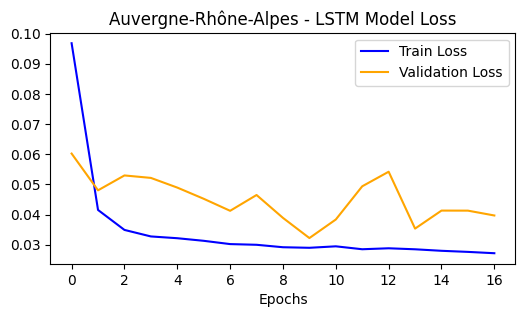

Forecasting for Bourgogne-Franche-Comté
Epoch 1/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.1209 - mse: 0.0424 - val_loss: 0.0720 - val_mse: 0.0168
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0435 - mse: 0.0048 - val_loss: 0.0632 - val_mse: 0.0141
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0380 - mse: 0.0040 - val_loss: 0.0639 - val_mse: 0.0147
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0374 - mse: 0.0041 - val_loss: 0.0560 - val_mse: 0.0114
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0343 - mse: 0.0036 - val_loss: 0.0556 - val_mse: 0.0114
Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0342 - mse: 0.0036 - val_loss: 0.0557 - val_mse: 0.0111
Epoch 7/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0335 - mse: 0.0035 - val_loss: 0.0578 - val_mse: 0.0124
Epoch 8/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0321 - mse: 0.0033 - val_loss: 0.0518 - val_mse: 0.0099
Epoch 9/50
40/40 ━━━━━━━

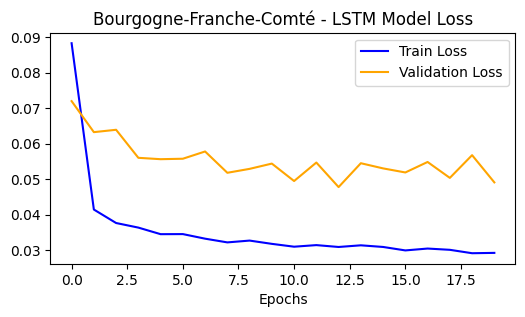

Forecasting for Pays-de-la-Loire
Epoch 1/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - loss: 0.1132 - mse: 0.0383 - val_loss: 0.0560 - val_mse: 0.0094
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0409 - mse: 0.0041 - val_loss: 0.0556 - val_mse: 0.0098
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.0358 - mse: 0.0035 - val_loss: 0.0508 - val_mse: 0.0079
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0334 - mse: 0.0031 - val_loss: 0.0534 - val_mse: 0.0092
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.0333 - mse: 0.0032 - val_loss: 0.0513 - val_mse: 0.0087
Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0331 - mse: 0.0031 - val_loss: 0.0534 - val_mse: 0.0091
Epoch 7/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0317 - mse: 0.0029 - val_loss: 0.0491 - val_mse: 0.0082
Epoch 8/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0303 - mse: 0.0028 - val_loss: 0.0453 - val_mse: 0.0070
Epoch 9/50
40/40 ━━━━━━━━━━━━━━

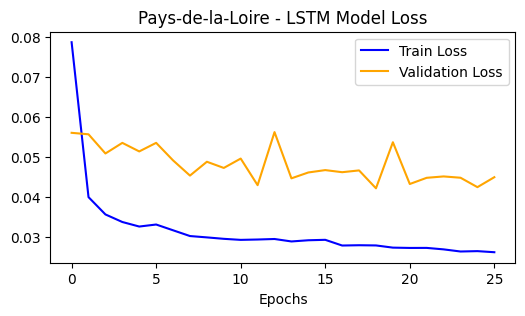

Forecasting for Bretagne
Epoch 1/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 50ms/step - loss: 0.1256 - mse: 0.0474 - val_loss: 0.0548 - val_mse: 0.0090
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0436 - mse: 0.0047 - val_loss: 0.0468 - val_mse: 0.0066
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0383 - mse: 0.0039 - val_loss: 0.0483 - val_mse: 0.0077
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0363 - mse: 0.0036 - val_loss: 0.0456 - val_mse: 0.0067
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0338 - mse: 0.0033 - val_loss: 0.0466 - val_mse: 0.0075
Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0341 - mse: 0.0035 - val_loss: 0.0453 - val_mse: 0.0070
Epoch 7/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0332 - mse: 0.0033 - val_loss: 0.0469 - val_mse: 0.0080
Epoch 8/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.0314 - mse: 0.0030 - val_loss: 0.0486 - val_mse: 0.0084
Epoch 9/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 2

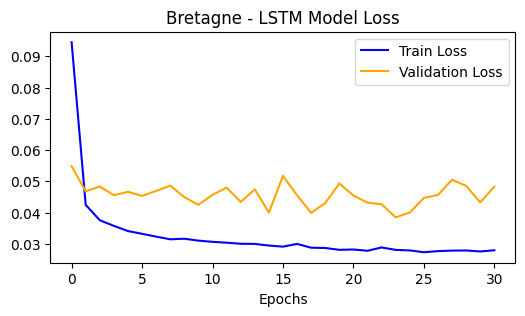

Forecasting for Centre-Val de Loire
Epoch 1/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - loss: 0.0933 - mse: 0.0271 - val_loss: 0.0842 - val_mse: 0.0242
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0363 - mse: 0.0039 - val_loss: 0.0666 - val_mse: 0.0147
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0334 - mse: 0.0035 - val_loss: 0.0632 - val_mse: 0.0136
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0298 - mse: 0.0029 - val_loss: 0.0648 - val_mse: 0.0148
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0303 - mse: 0.0031 - val_loss: 0.0662 - val_mse: 0.0154
Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0285 - mse: 0.0028 - val_loss: 0.0638 - val_mse: 0.0142
Epoch 7/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0274 - mse: 0.0026 - val_loss: 0.0564 - val_mse: 0.0117
Epoch 8/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 0.0281 - mse: 0.0027 - val_loss: 0.0513 - val_mse: 0.0094
Epoch 9/50
40/40 ━━━━━━━━━━━

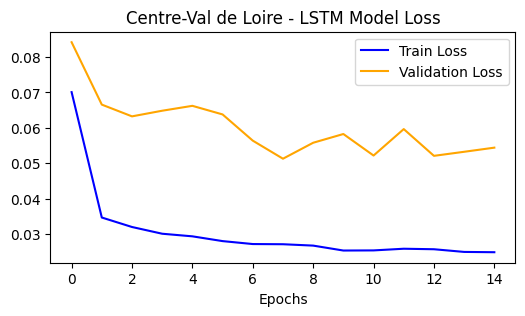

Forecasting for Grand-Est
Epoch 1/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - loss: 0.0766 - mse: 0.0162 - val_loss: 0.0393 - val_mse: 0.0050
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0346 - mse: 0.0036 - val_loss: 0.0308 - val_mse: 0.0029
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0334 - mse: 0.0036 - val_loss: 0.0334 - val_mse: 0.0038
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0308 - mse: 0.0034 - val_loss: 0.0248 - val_mse: 0.0020
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0303 - mse: 0.0032 - val_loss: 0.0256 - val_mse: 0.0022
Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0291 - mse: 0.0031 - val_loss: 0.0282 - val_mse: 0.0027
Epoch 7/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0281 - mse: 0.0029 - val_loss: 0.0240 - val_mse: 0.0020
Epoch 8/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0273 - mse: 0.0028 - val_loss: 0.0241 - val_mse: 0.0022
Epoch 9/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 

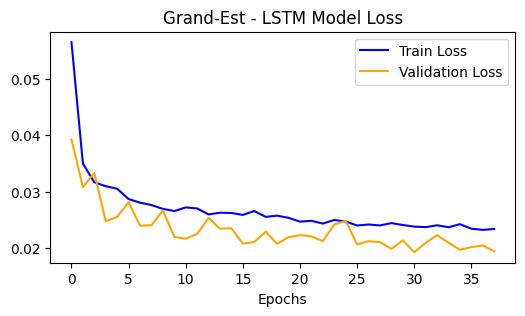

Forecasting for Hauts-de-France
Epoch 1/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 48ms/step - loss: 0.0707 - mse: 0.0144 - val_loss: 0.0885 - val_mse: 0.0280
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0323 - mse: 0.0031 - val_loss: 0.0863 - val_mse: 0.0282
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0293 - mse: 0.0027 - val_loss: 0.0798 - val_mse: 0.0246
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0288 - mse: 0.0028 - val_loss: 0.0694 - val_mse: 0.0192
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0272 - mse: 0.0025 - val_loss: 0.0749 - val_mse: 0.0222
Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0279 - mse: 0.0026 - val_loss: 0.0721 - val_mse: 0.0210
Epoch 7/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0259 - mse: 0.0023 - val_loss: 0.0672 - val_mse: 0.0185
Epoch 8/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0256 - mse: 0.0023 - val_loss: 0.0655 - val_mse: 0.0175
Epoch 9/50
40/40 ━━━━━━━━━━━━━━━

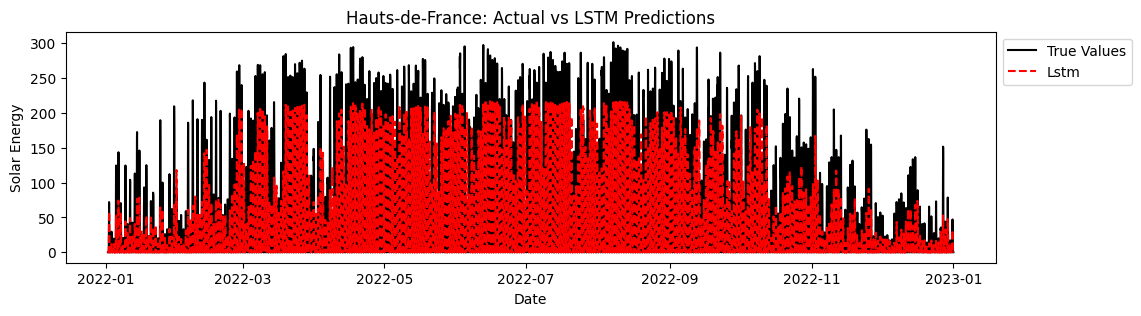

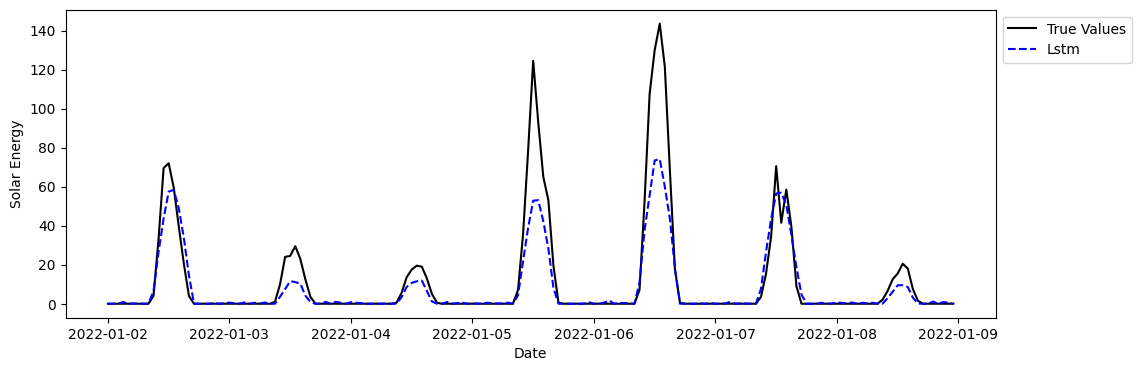

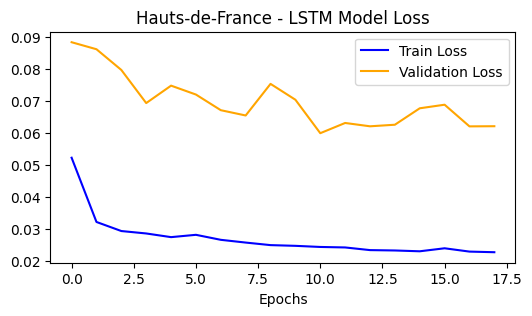

Forecasting for Ile-de-France
Epoch 1/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 8s 52ms/step - loss: 0.0986 - mse: 0.0289 - val_loss: 0.0754 - val_mse: 0.0199
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0404 - mse: 0.0048 - val_loss: 0.0625 - val_mse: 0.0139
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0359 - mse: 0.0040 - val_loss: 0.0701 - val_mse: 0.0179
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0356 - mse: 0.0040 - val_loss: 0.0642 - val_mse: 0.0150
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0346 - mse: 0.0040 - val_loss: 0.0646 - val_mse: 0.0151
Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0331 - mse: 0.0037 - val_loss: 0.0558 - val_mse: 0.0116
Epoch 7/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0332 - mse: 0.0038 - val_loss: 0.0611 - val_mse: 0.0136
Epoch 8/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0328 - mse: 0.0037 - val_loss: 0.0684 - val_mse: 0.0168
Epoch 9/50
40/40 ━━━━━━━━━━━━━━━━━

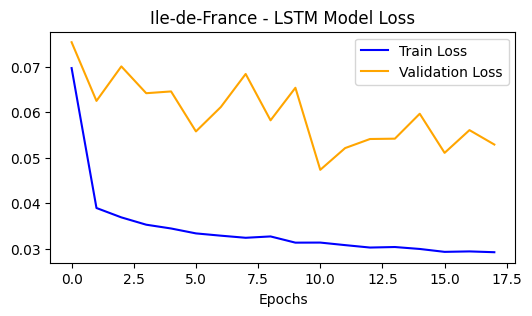

Forecasting for Normandie
Epoch 1/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 52ms/step - loss: 0.1068 - mse: 0.0345 - val_loss: 0.0569 - val_mse: 0.0098
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0425 - mse: 0.0046 - val_loss: 0.0492 - val_mse: 0.0075
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0369 - mse: 0.0036 - val_loss: 0.0483 - val_mse: 0.0080
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0368 - mse: 0.0038 - val_loss: 0.0443 - val_mse: 0.0066
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0346 - mse: 0.0034 - val_loss: 0.0451 - val_mse: 0.0074
Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0329 - mse: 0.0033 - val_loss: 0.0448 - val_mse: 0.0073
Epoch 7/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0332 - mse: 0.0034 - val_loss: 0.0442 - val_mse: 0.0071
Epoch 8/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0321 - mse: 0.0032 - val_loss: 0.0416 - val_mse: 0.0065
Epoch 9/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 

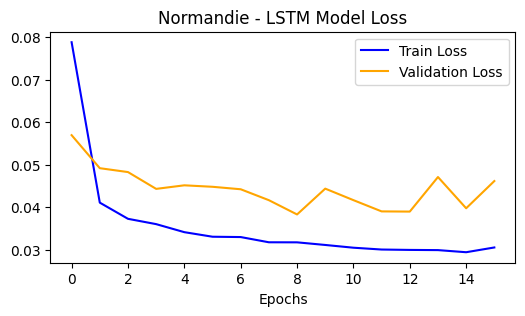

Forecasting for Nouvelle-Aquitaine
Epoch 1/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 53ms/step - loss: 0.1003 - mse: 0.0275 - val_loss: 0.0481 - val_mse: 0.0061
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0397 - mse: 0.0038 - val_loss: 0.0483 - val_mse: 0.0069
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.0362 - mse: 0.0035 - val_loss: 0.0390 - val_mse: 0.0043
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0338 - mse: 0.0031 - val_loss: 0.0408 - val_mse: 0.0052
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0319 - mse: 0.0029 - val_loss: 0.0399 - val_mse: 0.0049
Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.0316 - mse: 0.0028 - val_loss: 0.0431 - val_mse: 0.0059
Epoch 7/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0302 - mse: 0.0027 - val_loss: 0.0370 - val_mse: 0.0043
Epoch 8/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.0306 - mse: 0.0027 - val_loss: 0.0344 - val_mse: 0.0037
Epoch 9/50
40/40 ━━━━━━━━━━━━

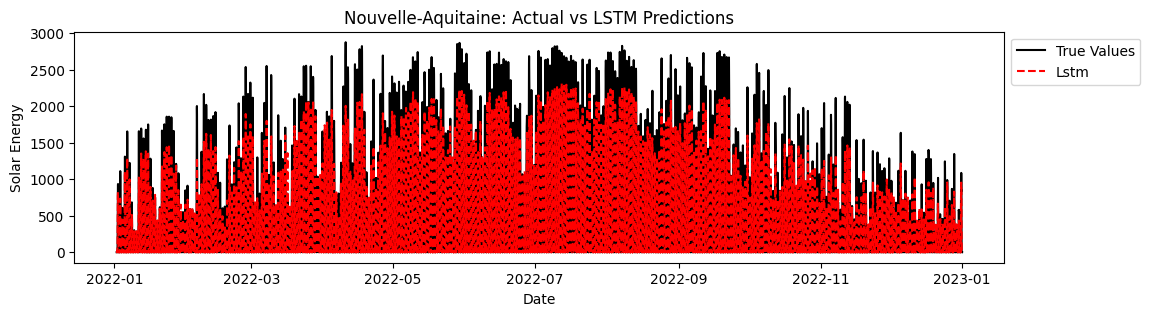

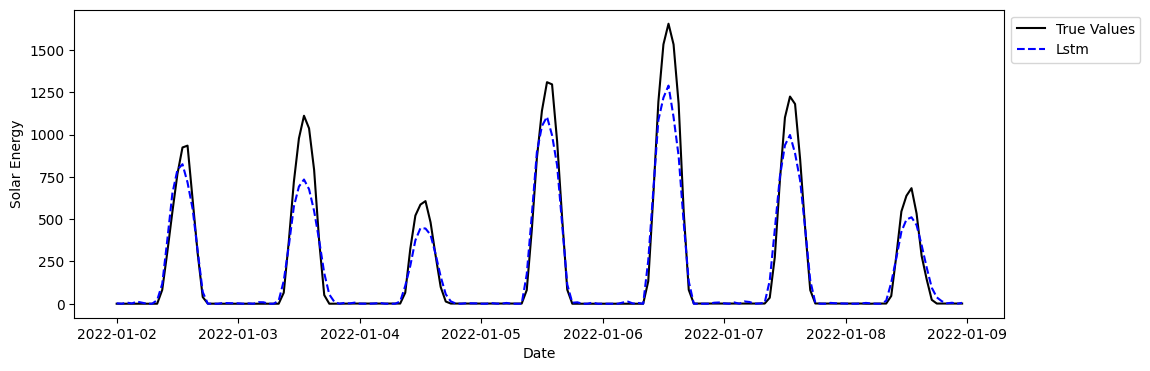

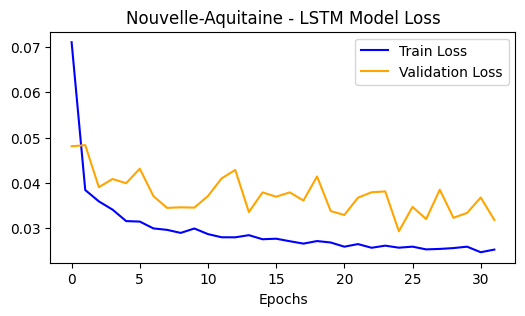

Forecasting for Occitanie
Epoch 1/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 50ms/step - loss: 0.1136 - mse: 0.0383 - val_loss: 0.0515 - val_mse: 0.0069
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0392 - mse: 0.0037 - val_loss: 0.0506 - val_mse: 0.0074
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0346 - mse: 0.0030 - val_loss: 0.0518 - val_mse: 0.0080
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0331 - mse: 0.0029 - val_loss: 0.0463 - val_mse: 0.0063
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0315 - mse: 0.0027 - val_loss: 0.0442 - val_mse: 0.0060
Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0303 - mse: 0.0026 - val_loss: 0.0499 - val_mse: 0.0078
Epoch 7/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0295 - mse: 0.0025 - val_loss: 0.0486 - val_mse: 0.0072
Epoch 8/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0298 - mse: 0.0026 - val_loss: 0.0490 - val_mse: 0.0076
Epoch 9/50
40/40 ━━━━━━━━━━━━━━━━━━━━

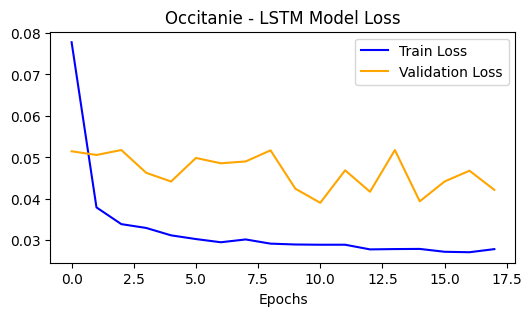

Forecasting for PACA
Epoch 1/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 8s 50ms/step - loss: 0.1398 - mse: 0.0581 - val_loss: 0.0642 - val_mse: 0.0103
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0445 - mse: 0.0046 - val_loss: 0.0553 - val_mse: 0.0086
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0379 - mse: 0.0037 - val_loss: 0.0470 - val_mse: 0.0067
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0348 - mse: 0.0033 - val_loss: 0.0381 - val_mse: 0.0046
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0330 - mse: 0.0030 - val_loss: 0.0384 - val_mse: 0.0044
Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0317 - mse: 0.0029 - val_loss: 0.0417 - val_mse: 0.0054
Epoch 7/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0307 - mse: 0.0028 - val_loss: 0.0393 - val_mse: 0.0048
Epoch 8/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0297 - mse: 0.0026 - val_loss: 0.0399 - val_mse: 0.0048
Epoch 9/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 34

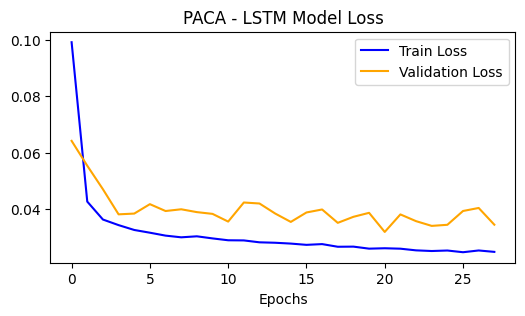

In [14]:
random.seed(100457522)

lstm_results = {}
input_width = 24
forecast_horizon=24


for region, region_data in region_dfs.items():
    print(f"Forecasting for {region}")
    energy_train = region_data['energy_train']
    weather_train = region_data['weather_train']
    energy_val = region_data['energy_val']
    weather_val = region_data['weather_val']
    energy_test = region_data['energy_test']
    weather_test = region_data['weather_test']

    # add 1% of error to future weather data
    weather_train = add_weather_error(weather_train)
    weather_val = add_weather_error(weather_val)
    weather_test = add_weather_error(weather_test)

    # create sequences
    X_energy_train, X_weather_train, y_train = create_daily_blocks(energy_train, weather_train)
    X_energy_val, X_weather_val, y_val = create_daily_blocks(energy_val, weather_val)
    X_energy_test, X_weather_test, y_test = create_daily_blocks(energy_test, weather_test)

    # reshape energy to 3D (N, 24, 1)
    X_energy_train_3D = X_energy_train[..., np.newaxis]  # shape (N, 24, 1)
    X_energy_val_3D = X_energy_val[..., np.newaxis]
    X_energy_test_3D  = X_energy_test[..., np.newaxis]

    # join energy and weather
    X_train_combined = np.concatenate([X_energy_train_3D, X_weather_train], axis=-1)
    X_val_combined = np.concatenate([X_energy_val_3D, X_weather_val], axis=-1)
    X_test_combined  = np.concatenate([X_energy_test_3D, X_weather_test], axis=-1)

    # flatten to scale (shapes not matching)
    X_train_flat = X_train_combined.reshape(-1, X_train_combined.shape[-1])
    X_val_flat = X_val_combined.reshape(-1, X_val_combined.shape[-1])
    X_test_flat  = X_test_combined.reshape(-1, X_test_combined.shape[-1])

    # scale the data
    scaler_X = MinMaxScaler()
    X_train_scaled_flat = scaler_X.fit_transform(X_train_flat)
    X_val_scaled_flat = scaler_X.transform(X_val_flat)
    X_test_scaled_flat  = scaler_X.transform(X_test_flat)

    # Reshape back to original 
    X_train_scaled = X_train_scaled_flat.reshape(X_train_combined.shape)
    X_val_scaled = X_val_scaled_flat.reshape(X_val_combined.shape)
    X_test_scaled  = X_test_scaled_flat.reshape(X_test_combined.shape)

    scaler_y = MinMaxScaler()
    y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).reshape(y_train.shape)
    y_val_scaled = scaler_y.transform(y_val.reshape(-1,1)).reshape(y_val.shape)
    y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).reshape(y_test.shape)

    # fit cnn gru model
    input_shape = X_train_scaled.shape[1:]
    lstm_model = build_lstm(input_shape, forecast_horizon)
    history = fit_cnn_gru_model(lstm_model, 
                                X_train_scaled, y_train_scaled,
                                X_val_scaled, y_val_scaled)
    history_mse = history

    # predict
    y_pred_lstm= lstm_model.predict(X_test_scaled)
    y_pred_lstm = scaler_y.inverse_transform(y_pred_lstm).flatten()
    y_pred_lstm = np.maximum(y_pred_lstm, 0) # set negatives to 0

    y_true = pd.Series(y_test.flatten(), index=energy_test.index[24:])

    eval_lstm = evaluate(y_true, y_pred_lstm, 'LSTM')
    if region in chosen_regions:
        evaluate_plot(y_true, y_pred_lstm, 'LSTM', region)

    lstm_results[region] = {
        'y_true': y_true,
        'y_pred_lstm': y_pred_lstm,
        'mae': eval_lstm['MAE'],
        'rmse': eval_lstm['RMSE'],
        'nrmse': eval_lstm['NRMSE']
    }

    # Plot loss and val loss
    plt.figure(figsize=(6, 3))
    plt.plot(history.history['loss'], label='Train Loss', color='blue')
    plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
    plt.xlabel('Epochs')
    plt.title(f'{region} - LSTM Model Loss')
    plt.legend()
    plt.show()




## Results

In [15]:
all_results = {
    'Naive': naive_results,
    'Prophet': prophet_results,
    'XGB': xgboost_results,
    'CNN-GRU': cnn_gru_results, 
    'LSTM': lstm_results
}

records = []

for model_name, regions in all_results.items():
    for region_name, metrics in regions.items():
        record = {
            'Region': region_name,
            'Model': model_name, 
            'MAE': metrics['mae'],
            'RMSE': metrics['rmse'],
            'NRMSE': metrics['nrmse']
        }
        records.append(record)

df_results = pd.DataFrame(records)


In [23]:
df_results.to_csv('results/df_results_solar_all.csv')

In [18]:
comparative_region_df = round(df_results[(df_results['Region'] == 'Nouvelle-Aquitaine') | (df_results['Region'] == 'Hauts-de-France')], 3)
comparative_region_df.to_csv('results/comparative_region_df.csv')
print(comparative_region_df.to_latex(float_format='%.3f'))

\begin{tabular}{lllrrr}
\toprule
 & Region & Model & MAE & RMSE & NRMSE \\
\midrule
6 & Hauts-de-France & Naive & 17.209 & 37.741 & 0.715 \\
9 & Nouvelle-Aquitaine & Naive & 145.594 & 308.943 & 0.575 \\
18 & Hauts-de-France & Prophet & 55.129 & 61.554 & 1.167 \\
21 & Nouvelle-Aquitaine & Prophet & 269.989 & 359.457 & 0.669 \\
30 & Hauts-de-France & XGB & 23.058 & 43.975 & 0.834 \\
33 & Nouvelle-Aquitaine & XGB & 131.395 & 246.443 & 0.459 \\
42 & Hauts-de-France & CNN-GRU & 16.356 & 32.620 & 0.618 \\
45 & Nouvelle-Aquitaine & CNN-GRU & 130.030 & 240.200 & 0.447 \\
54 & Hauts-de-France & LSTM & 18.233 & 34.272 & 0.650 \\
57 & Nouvelle-Aquitaine & LSTM & 119.208 & 217.587 & 0.405 \\
\bottomrule
\end{tabular}



In [19]:
df_pivot = df_results.pivot(index='Region', columns='Model', values=['MAE', 'RMSE', 'NRMSE'])
# Swap the column levels: make Model the first level, Metric the second
df_pivot.columns = df_pivot.columns.swaplevel(0, 1)

# # Optional: Sort columns so models are grouped together
df_pivot = df_pivot.sort_index(axis=1, level=0)
#print(df_pivot.to_latex(float_format="%.3f"))
df_pivot

Model                       CNN-GRU                              LSTM  \
                                MAE     NRMSE        RMSE         MAE   
Region                                                                  
Auvergne-Rhône-Alpes      62.543306  0.487552  113.611489   52.914921   
Bourgogne-Franche-Comté   28.306118  0.696775   53.754104   27.683961   
Bretagne                  25.479701  1.052263   45.758459   13.027363   
Centre-Val de Loire       37.231477  0.663981   69.612621   33.380681   
Grand-Est                 33.201398  0.440133   61.972830   28.186084   
Hauts-de-France           16.355761  0.618379   32.619932   18.233186   
Ile-de-France              7.875207  0.635021   15.185904    6.724089   
Normandie                  9.129562  0.562910   17.285540    8.600619   
Nouvelle-Aquitaine       130.030180  0.447038  240.200319  119.207974   
Occitanie                122.853061  0.518363  224.107034  112.537610   
PACA                      75.582952  0.439942  130.437810   57.561192   
Pays-de-la-Loire          36.305734  0.598733   67.092152   33.024321   

Model                                               Naive            \
                            NRMSE        RMSE         MAE     NRMSE   
Region                                                                
Auvergne-Rhône-Alpes     0.409176   95.347919   54.103136  0.503917   
Bourgogne-Franche-Comté  0.670988   51.764748   21.502976  0.615945   
Bretagne                 0.574331   24.975218   12.834364  0.639466   
Centre-Val de Loire      0.593081   62.179383   30.131639  0.636644   
Grand-Est                0.388347   54.681115   40.121623  0.623364   
Hauts-de-France          0.649698   34.272023   17.209478  0.715452   
Ile-de-France            0.555661   13.288087    8.148294  0.740811   
Normandie                0.531574   16.323288   10.164721  0.716662   
Nouvelle-Aquitaine       0.404953  217.587216  145.594036  0.574976   
Occitanie                0.471660  203.915685  102.093864  0.501092   
PACA                     0.347445  103.013556   64.152988  0.510078   
Pays-de-la-Loire         0.542942   60.840342   31.923363  0.615617   

Model                                   Prophet                        \
                               RMSE         MAE     NRMSE        RMSE   
Region                                                                  
Auvergne-Rhône-Alpes     117.424971  133.582363  0.736077  171.523867   
Bourgogne-Franche-Comté   47.518345   46.351240  0.910878   70.271570   
Bretagne                  27.807654   21.364105  0.783917   34.089236   
Centre-Val de Loire       66.746575   97.797539  1.069072  112.082995   
Grand-Est                 87.772694  106.291074  0.867128  122.095802   
Hauts-de-France           37.740603   55.129337  1.166886   61.554046   
Ile-de-France             17.715771   18.594232  0.943679   22.567161   
Normandie                 22.006883   21.328711  0.838862   25.759328   
Nouvelle-Aquitaine       308.943496  269.989306  0.668987  359.456806   
Occitanie                216.640216  213.172624  0.658222  284.573144   
PACA                     151.232382  124.267803  0.630675  186.988110   
Pays-de-la-Loire          68.984073   67.129981  0.772034   86.511681   

Model                           XGB                        
                                MAE     NRMSE        RMSE  
Region                                                     
Auvergne-Rhône-Alpes      73.008992  0.577542  134.581308  
Bourgogne-Franche-Comté   31.426685  0.766240   59.113160  
Bretagne                  13.746347  0.614436   26.719209  
Centre-Val de Loire       41.322842  0.754039   79.054432  
Grand-Est                 32.262427  0.453300   63.826830  
Hauts-de-France           23.058471  0.833644   43.975278  
Ile-de-France              8.450116  0.693730   16.589883  
Normandie                  8.376986  0.546645   16.786088  
Nouvelle-Aquitaine       131.395410  0.458656  246.443132  
Occitanie             

In [20]:
# Step 2: Define custom model and metric order
model_order = ['Naive', 'Prophet', 'XGB', 'CNN-GRU', 'LSTM']
metric_order = ['MAE', 'RMSE', 'NRMSE']

# Step 3: Create sorted MultiIndex based on your custom order
ordered_columns = [(model, metric) for model in model_order for metric in metric_order if (model, metric) in df_pivot.columns]

# Step 4: Apply reordering
df_pivot = df_pivot[ordered_columns]
df_pivot

Model                         Naive                           Prophet  \
                                MAE        RMSE     NRMSE         MAE   
Region                                                                  
Auvergne-Rhône-Alpes      54.103136  117.424971  0.503917  133.582363   
Bourgogne-Franche-Comté   21.502976   47.518345  0.615945   46.351240   
Bretagne                  12.834364   27.807654  0.639466   21.364105   
Centre-Val de Loire       30.131639   66.746575  0.636644   97.797539   
Grand-Est                 40.121623   87.772694  0.623364  106.291074   
Hauts-de-France           17.209478   37.740603  0.715452   55.129337   
Ile-de-France              8.148294   17.715771  0.740811   18.594232   
Normandie                 10.164721   22.006883  0.716662   21.328711   
Nouvelle-Aquitaine       145.594036  308.943496  0.574976  269.989306   
Occitanie                102.093864  216.640216  0.501092  213.172624   
PACA                      64.152988  151.232382  0.510078  124.267803   
Pays-de-la-Loire          31.923363   68.984073  0.615617   67.129981   

Model                                                 XGB              \
                               RMSE     NRMSE         MAE        RMSE   
Region                                                                  
Auvergne-Rhône-Alpes     171.523867  0.736077   73.008992  134.581308   
Bourgogne-Franche-Comté   70.271570  0.910878   31.426685   59.113160   
Bretagne                  34.089236  0.783917   13.746347   26.719209   
Centre-Val de Loire      112.082995  1.069072   41.322842   79.054432   
Grand-Est                122.095802  0.867128   32.262427   63.826830   
Hauts-de-France           61.554046  1.166886   23.058471   43.975278   
Ile-de-France             22.567161  0.943679    8.450116   16.589883   
Normandie                 25.759328  0.838862    8.376986   16.786088   
Nouvelle-Aquitaine       359.456806  0.668987  131.395410  246.443132   
Occitanie                284.573144  0.658222  111.936392  205.932056   
PACA                     186.988110  0.630675   67.424623  121.494181   
Pays-de-la-Loire          86.511681  0.772034   33.852185   64.743475   

Model                                 CNN-GRU                        \
                            NRMSE         MAE        RMSE     NRMSE   
Region                                                                
Auvergne-Rhône-Alpes     0.577542   62.543306  113.611489  0.487552   
Bourgogne-Franche-Comté  0.766240   28.306118   53.754104  0.696775   
Bretagne                 0.614436   25.479701   45.758459  1.052263   
Centre-Val de Loire      0.754039   37.231477   69.612621  0.663981   
Grand-Est                0.453300   33.201398   61.972830  0.440133   
Hauts-de-France          0.833644   16.355761   32.619932  0.618379   
Ile-de-France            0.693730    7.875207   15.185904  0.635021   
Normandie                0.546645    9.129562   17.285540  0.562910   
Nouvelle-Aquitaine       0.458656  130.030180  240.200319  0.447038   
Occitanie                0.476324  122.853061  224.107034  0.518363   
PACA                     0.409776   75.582952  130.437810  0.439942   
Pays-de-la-Loire         0.577773   36.305734   67.092152  0.598733   

Model                          LSTM                        
                                MAE        RMSE     NRMSE  
Region                                                     
Auvergne-Rhône-Alpes      52.914921   95.347919  0.409176  
Bourgogne-Franche-Comté   27.683961   51.764748  0.670988  
Bretagne                  13.027363   24.975218  0.574331  
Centre-Val de Loire       33.380681   62.179383  0.593081  
Grand-Est                 28.186084   54.681115  0.388347  
Hauts-de-France           18.233186   34.272023  0.649698  
Ile-de-France              6.724089   13.288087  0.555661  
Normandie                  8.600619   16.323288  0.531574  
Nouvelle-Aquitaine       119.207974  217.587216  0.404953  
Occitanie             

In [21]:
avg_row = df_pivot.mean(axis=0)

# Append the average as a new row at the bottom
df_pivot.loc['Average'] = avg_row
df_pivot

C:\Users\melan\AppData\Local\Temp\ipykernel_26280\2674168960.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pivot.loc['Average'] = avg_row


Model                         Naive                           Prophet  \
                                MAE        RMSE     NRMSE         MAE   
Region                                                                  
Auvergne-Rhône-Alpes      54.103136  117.424971  0.503917  133.582363   
Bourgogne-Franche-Comté   21.502976   47.518345  0.615945   46.351240   
Bretagne                  12.834364   27.807654  0.639466   21.364105   
Centre-Val de Loire       30.131639   66.746575  0.636644   97.797539   
Grand-Est                 40.121623   87.772694  0.623364  106.291074   
Hauts-de-France           17.209478   37.740603  0.715452   55.129337   
Ile-de-France              8.148294   17.715771  0.740811   18.594232   
Normandie                 10.164721   22.006883  0.716662   21.328711   
Nouvelle-Aquitaine       145.594036  308.943496  0.574976  269.989306   
Occitanie                102.093864  216.640216  0.501092  213.172624   
PACA                      64.152988  151.232382  0.510078  124.267803   
Pays-de-la-Loire          31.923363   68.984073  0.615617   67.129981   
Average                   44.831707   97.544472  0.616169   97.916526   

Model                                                 XGB              \
                               RMSE     NRMSE         MAE        RMSE   
Region                                                                  
Auvergne-Rhône-Alpes     171.523867  0.736077   73.008992  134.581308   
Bourgogne-Franche-Comté   70.271570  0.910878   31.426685   59.113160   
Bretagne                  34.089236  0.783917   13.746347   26.719209   
Centre-Val de Loire      112.082995  1.069072   41.322842   79.054432   
Grand-Est                122.095802  0.867128   32.262427   63.826830   
Hauts-de-France           61.554046  1.166886   23.058471   43.975278   
Ile-de-France             22.567161  0.943679    8.450116   16.589883   
Normandie                 25.759328  0.838862    8.376986   16.786088   
Nouvelle-Aquitaine       359.456806  0.668987  131.395410  246.443132   
Occitanie                284.573144  0.658222  111.936392  205.932056   
PACA                     186.988110  0.630675   67.424623  121.494181   
Pays-de-la-Loire          86.511681  0.772034   33.852185   64.743475   
Average                  128.122812  0.837201   48.021790   89.938253   

Model                                 CNN-GRU                        \
                            NRMSE         MAE        RMSE     NRMSE   
Region                                                                
Auvergne-Rhône-Alpes     0.577542   62.543306  113.611489  0.487552   
Bourgogne-Franche-Comté  0.766240   28.306118   53.754104  0.696775   
Bretagne                 0.614436   25.479701   45.758459  1.052263   
Centre-Val de Loire      0.754039   37.231477   69.612621  0.663981   
Grand-Est                0.453300   33.201398   61.972830  0.440133   
Hauts-de-France          0.833644   16.355761   32.619932  0.618379   
Ile-de-France            0.693730    7.875207   15.185904  0.635021   
Normandie                0.546645    9.129562   17.285540  0.562910   
Nouvelle-Aquitaine       0.458656  130.030180  240.200319  0.447038   
Occitanie                0.476324  122.853061  224.107034  0.518363   
PACA                     0.409776   75.582952  130.437810  0.439942   
Pays-de-la-Loire         0.577773   36.305734   67.092152  0.598733   
Average                  0.596842   48.741205   89.303183  0.596757   

Model                          LSTM                        
                                MAE        RMSE     NRMSE  
Region                                                     
Auvergne-Rhône-Alpes      52.914921   95.347919  0.409176  
Bourgogne-Franche-Comté   27.683961   51.764748  0.670988  
Bretagne                  13.027363   24.975218  0.574331  
Centre-Val de Loire       33.380681   62.179383  0.593081  
Grand-Est                 28.186084   54.681115  0.388347  
Hauts-de-France           18.233186   34.2720

In [24]:
print(df_pivot.to_latex(float_format="%.3f"))

\begin{tabular}{lrrrrrrrrrrrrrrr}
\toprule
Model & \multicolumn{3}{r}{Naive} & \multicolumn{3}{r}{Prophet} & \multicolumn{3}{r}{XGB} & \multicolumn{3}{r}{CNN-GRU} & \multicolumn{3}{r}{LSTM} \\
 & MAE & RMSE & NRMSE & MAE & RMSE & NRMSE & MAE & RMSE & NRMSE & MAE & RMSE & NRMSE & MAE & RMSE & NRMSE \\
Region &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  \\
\midrule
Auvergne-Rhône-Alpes & 54.103 & 117.425 & 0.504 & 133.582 & 171.524 & 0.736 & 73.009 & 134.581 & 0.578 & 62.543 & 113.611 & 0.488 & 52.915 & 95.348 & 0.409 \\
Bourgogne-Franche-Comté & 21.503 & 47.518 & 0.616 & 46.351 & 70.272 & 0.911 & 31.427 & 59.113 & 0.766 & 28.306 & 53.754 & 0.697 & 27.684 & 51.765 & 0.671 \\
Bretagne & 12.834 & 27.808 & 0.639 & 21.364 & 34.089 & 0.784 & 13.746 & 26.719 & 0.614 & 25.480 & 45.758 & 1.052 & 13.027 & 24.975 & 0.574 \\
Centre-Val de Loire & 30.132 & 66.747 & 0.637 & 97.798 & 112.083 & 1.069 & 41.323 & 79.054 & 0.754 & 37.231 & 69.613 & 0.664 & 33.381 & 62.179 & 0.593 \\
Grand-Est & 40.122 & 8

In [3]:
# load data
df_results = pd.read_csv('results/df_results_solar_all.csv')
df_results

,Unnamed: 0,Region,Model,MAE,RMSE,NRMSE
0,0,Auvergne-Rhône-Alpes,Naive,54.103136,117.424971,0.503917
1,1,Bourgogne-Franche-Comté,Naive,21.502976,47.518345,0.615945
2,2,Pays-de-la-Loire,Naive,31.923363,68.984073,0.615617
3,3,Bretagne,Naive,12.834364,27.807654,0.639466
4,4,Centre-Val de Loire,Naive,30.131639,66.746575,0.636644
5,5,Grand-Est,Naive,40.121623,87.772694,0.623364
6,6,Hauts-de-France,Naive,17.209478,37.740603,0.715452
7,7,Ile-de-France,Naive,8.148294,17.715771,0.740811
8,8,Normandie,Naive,10.164721,22.006883,0.716662
9,9,Nouvelle-Aquitaine,Naive,145.594036,308.943496,0.574976


In [3]:
# Create a name mapping dictionary
name_mapping = {
    "Auvergne-Rhône-Alpes": "Auvergne-Rhône-Alpes",
    "Bourgogne-Franche-Comté": "Bourgogne-Franche-Comté",
    "Bretagne": "Bretagne",
    "Centre-Val-de-Loire": "Centre-Val de Loire",
    "Corse": "Corse",
    "Grand-Est": "Grand Est",
    "Hauts-de-France": "Hauts-de-France",
    "Ile-de-France": "Île-de-France",
    "Normandie": "Normandie",
    "Nouvelle-Aquitaine": "Nouvelle-Aquitaine",
    "Occitanie": "Occitanie",
    "Pays-de-la-Loire": "Pays de la Loire",
    "PACA": "Provence-Alpes-Côte d'Azur",
    "Guadeloupe": "Guadeloupe",
    "Martinique": "Martinique",
    "Guyane": "Guyane",
    "La Réunion": "La Réunion",
    "Mayotte": "Mayotte"
}

df_chloropleth = df_results.copy()
df_chloropleth['Region'] = df_chloropleth["Region"].replace(name_mapping)
df_chloropleth = df_chloropleth[['Region', 'Model', 'NRMSE']]

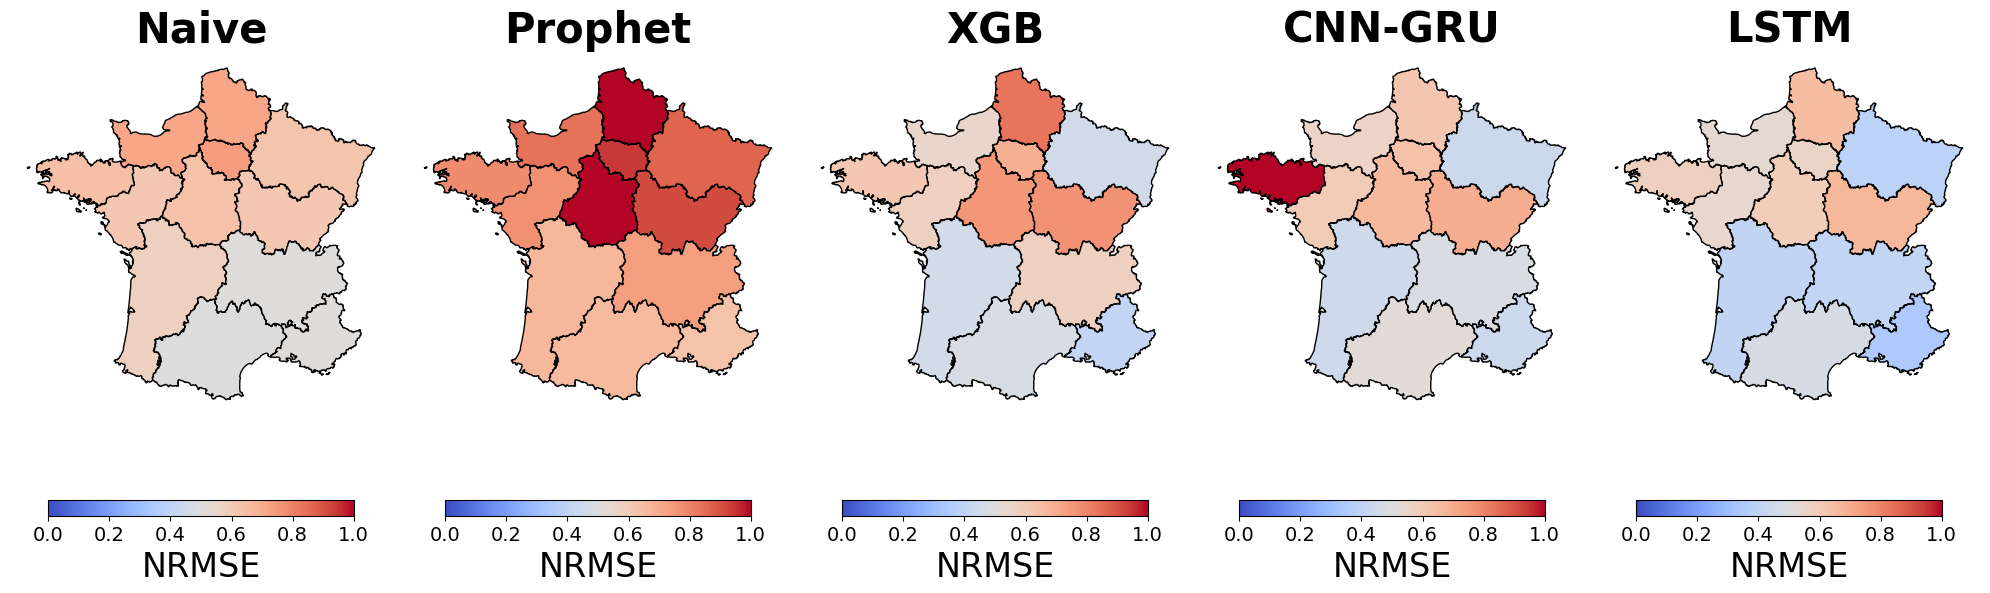

In [6]:
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib import font_manager

geojson_url = "data/france_regions.geojson"
gdf = gpd.read_file(geojson_url)
gdf = gdf.merge(df_chloropleth, how='left', left_on='nom', right_on='Region')

# Only keep matched regions
gdf_filtered = gdf[gdf['Region'].notna()].copy()
models = gdf_filtered.Model.unique()

fig, ax = plt.subplots(1, 5, figsize=(20, 6)) 
for i, c_model in enumerate(models):
    gdf_filtered_model = gdf_filtered[gdf_filtered['Model'] == c_model]

    plot = gdf_filtered_model.plot(
        column='NRMSE',
        ax=ax[i],
        legend=True,
        cmap='coolwarm',
        edgecolor='black',
        linewidth=1,
        vmin=0, vmax=1, 
        legend_kwds={
            'label': f"NRMSE",
            'orientation': "horizontal", 'shrink':0.8
        }
    )
    ax[i].set_title(c_model, size=30, fontweight='bold')
    ax[i].set_axis_off()
    cbar = plot.get_figure().axes[-1]  # This gets the colorbar axis
    cbar.tick_params(labelsize=14)     # Set tick label size
    cbar.set_xlabel(cbar.get_xlabel(), fontsize=24) 

plt.tight_layout()
plt.show()

fig.savefig(f'figures/solar_error_map.pdf', transparent=True)


Hourly / Monthly Analisis

In [25]:
records2 = []
model_keys = {
    'Naive': 'y_pred_naive',
    'Prophet': 'y_pred_prophet',
    'XGB': 'y_pred_xgb',
    'CNN-GRU': 'y_pred_cnn_gru',
    'LSTM': 'y_pred_lstm'
}

# Get list of all regions from any model (assume all models cover same regions)
regions = next(iter(all_results.values())).keys()

for region_name in regions:
    # Get y_true from any model (assume all models share the same y_true per region)
    y_true = all_results['Naive'][region_name]['y_true']
    datetime_index = y_true.index

    for i in range(len(y_true)):
        record = {
            'datetime': datetime_index[i],
            'Region': region_name,
            'y_true': y_true.iloc[i] if isinstance(y_true, pd.Series) else y_true[i]
        }

        for model_name, pred_key in model_keys.items():
            y_pred = all_results[model_name][region_name][pred_key]
            record[pred_key] = y_pred.iloc[i] if isinstance(y_pred, pd.Series) else y_pred[i]
        
        records2.append(record)

# Create the final DataFrame
df_all_predictions = pd.DataFrame(records2)
df_all_predictions['datetime'] = pd.to_datetime(df_all_predictions['datetime'])
df_all_predictions.set_index('datetime', inplace=True)
df_all_predictions['hour'] = df_all_predictions.index.hour
df_all_predictions['month'] = df_all_predictions.index.month

In [26]:
df_all_predictions.columns

Index(['Region', 'y_true', 'y_pred_naive', 'y_pred_prophet', 'y_pred_xgb',
       'y_pred_cnn_gru', 'y_pred_lstm', 'hour', 'month'],
      dtype='object')

In [4]:
#df_all_predictions.to_csv('results/solar_hourly_analysis_df.csv')
df_all_predictions = pd.read_csv('results/solar_hourly_analysis_df.csv')

In [5]:
hourly_metrics = []
model_keys = {
    'Naive': 'y_pred_naive',
    'Prophet': 'y_pred_prophet',
    'XGB': 'y_pred_xgb',
    'CNN-GRU': 'y_pred_cnn_gru',
    'LSTM': 'y_pred_lstm'
}

for model, model_pred in model_keys.items():
    hourly_df = df_all_predictions.groupby(['Region', 'hour']).apply(
        lambda x: pd.Series({
            'MAE': mean_absolute_error(x[model_pred], x['y_true'])
        })
    ).reset_index()
    hourly_df['model'] = model
    hourly_metrics.append(hourly_df)

df_hourly_analysis = pd.concat(hourly_metrics)
df_hourly_analysis

C:\Users\melan\AppData\Local\Temp\ipykernel_21220\1183730765.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  hourly_df = df_all_predictions.groupby(['Region', 'hour']).apply(
C:\Users\melan\AppData\Local\Temp\ipykernel_21220\1183730765.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  hourly_df = df_all_predictions.groupby(['Region', 'hour']).apply(
C:\Users\melan\AppData\Local\Temp\ipykernel_21220\

,Region,hour,MAE,model
0,Auvergne-Rhône-Alpes,0,0.000000,Naive
1,Auvergne-Rhône-Alpes,1,0.000000,Naive
2,Auvergne-Rhône-Alpes,2,0.000000,Naive
3,Auvergne-Rhône-Alpes,3,0.000000,Naive
4,Auvergne-Rhône-Alpes,4,0.000000,Naive
...,...,...,...,...
283,Pays-de-la-Loire,19,23.833734,LSTM
284,Pays-de-la-Loire,20,10.193615,LSTM
285,Pays-de-la-Loire,21,2.900806,LSTM
286,Pays-de-la-Loire,22,0.890063,LSTM


<Axes: xlabel='hour', ylabel='MAE'>

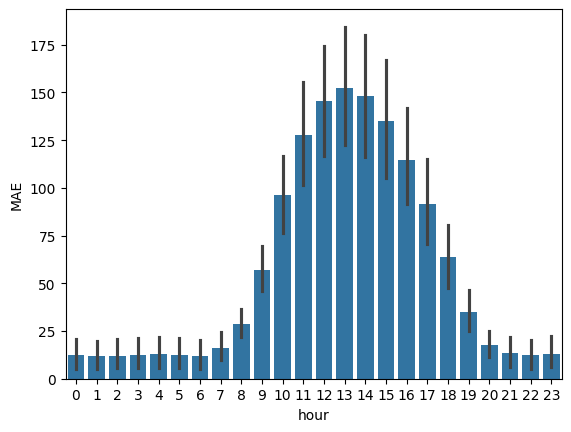

In [29]:
plt.Figure(figsize=(10,6))
sns.barplot(data=df_hourly_analysis, x ='hour', y = 'MAE')

In [7]:
regions = ['Nouvelle-Aquitaine', 'Hauts-de-France']

In [85]:
# Sample original coolwarm
coolwarm = plt.cm.coolwarm(np.linspace(0, 1, 5))

# Identify the middle index
mid_idx = len(coolwarm) // 2

# Darken the middle color by reducing RGB (leave alpha untouched)
coolwarm[mid_idx, :3] *= 0.6  # Scale RGB channels to make it darker
coolwarm = np.clip(coolwarm, 0, 1)
coolwarm

array([[0.2298057 , 0.29871797, 0.75368315, 1.        ],
       [0.55431187, 0.69009701, 0.99551555, 1.        ],
       [0.52045658, 0.51862596, 0.51756148, 1.        ],
       [0.95665321, 0.59803382, 0.47730229, 1.        ],
       [0.70567316, 0.01555616, 0.15023281, 1.        ]])

C:\Users\melan\AppData\Local\Temp\ipykernel_21220\1770234091.py:11: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  sns.lineplot(data=region_data, x='hour', y='MAE', hue='model',
C:\Users\melan\AppData\Local\Temp\ipykernel_21220\1770234091.py:11: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  sns.lineplot(data=region_data, x='hour', y='MAE', hue='model',


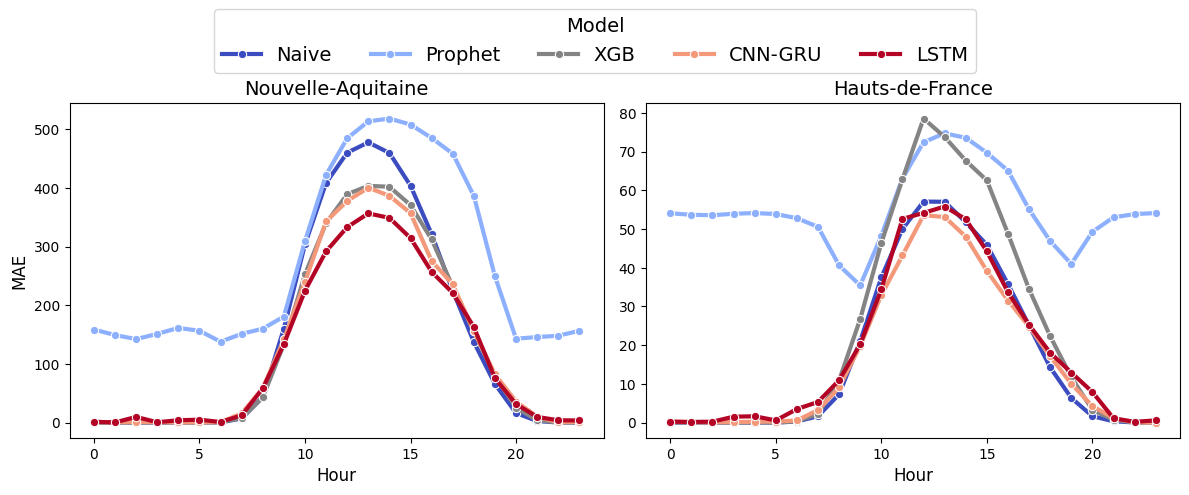

In [87]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=False)

for i, region in enumerate(regions):
    region_data = df_hourly_analysis[df_hourly_analysis['Region'] == region]


    sns.lineplot(data=region_data, x='hour', y='MAE', hue='model', 
                 palette=coolwarm, ax=axes[i], linewidth=3, marker='o')
    
    axes[i].set_title(region, fontsize=14)
    axes[i].set_xlabel('Hour', fontsize=12)
    axes[i].set_ylabel('MAE', fontsize=12 if i == 0 else 0)
    if i != 0:
        axes[i].set_ylabel('')
    axes[i].legend_.remove()

# Only one legend, outside the plots
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels,
            title='Model', fontsize=14, 
            title_fontsize=14, loc='upper center', ncol=len(labels))
plt.tight_layout(rect=[0, 0, 1, 0.87])
fig.savefig(f'figures/solar_hourly_plot.pdf')

plt.show()


In [179]:
pivot_mae = df_hourly_analysis.pivot_table(
    index='Region',       # rows
    columns='hour',      # columns
    values='MAE',         # values to aggregate
    aggfunc='mean'        # aggregation function (average)
)

print(pivot_mae.to_latex(float_format='%.2f'))

\begin{tabular}{lrrrrrrrrrrrrrrrrrrrrrrrr}
\toprule
hour & 0 & 1 & 2 & 3 & 4 & 5 & 6 & 7 & 8 & 9 & 10 & 11 & 12 & 13 & 14 & 15 & 16 & 17 & 18 & 19 & 20 & 21 & 22 & 23 \\
Region &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  \\
\midrule
Hauts-de-France & 3.22 & 2.90 & 4.40 & 3.15 & 3.78 & 3.35 & 2.84 & 4.80 & 9.70 & 23.15 & 38.94 & 53.69 & 61.82 & 62.15 & 59.07 & 52.57 & 42.40 & 33.33 & 22.66 & 12.81 & 5.58 & 3.70 & 2.77 & 3.39 \\
Nouvelle-Aquitaine & 28.11 & 25.51 & 24.69 & 25.58 & 27.77 & 27.05 & 23.77 & 36.76 & 71.89 & 152.36 & 272.33 & 362.37 & 413.16 & 428.24 & 424.09 & 392.08 & 342.42 & 277.89 & 207.17 & 116.22 & 48.92 & 30.11 & 25.74 & 28.46 \\
\bottomrule
\end{tabular}



In [11]:
monthly_metrics = []

for model, model_pred in model_keys.items():
    monthly_df = df_all_predictions.groupby(['Region', 'month']).apply(
        lambda x: pd.Series({
            'MAE': mean_absolute_error(x[model_pred], x['y_true'])
        })
    ).reset_index()
    monthly_df['model'] = model
    monthly_metrics.append(monthly_df)

df_monthly_analysis = pd.concat(monthly_metrics)
df_monthly_analysis

C:\Users\melan\AppData\Local\Temp\ipykernel_21220\3405113019.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  monthly_df = df_all_predictions.groupby(['Region', 'month']).apply(
C:\Users\melan\AppData\Local\Temp\ipykernel_21220\3405113019.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  monthly_df = df_all_predictions.groupby(['Region', 'month']).apply(
C:\Users\melan\AppData\Local\Temp\ipykernel_2122

,Region,month,MAE,model
0,Auvergne-Rhône-Alpes,1,27.888194,Naive
1,Auvergne-Rhône-Alpes,2,46.646577,Naive
2,Auvergne-Rhône-Alpes,3,49.297715,Naive
3,Auvergne-Rhône-Alpes,4,75.766667,Naive
4,Auvergne-Rhône-Alpes,5,54.088710,Naive
...,...,...,...,...
139,Pays-de-la-Loire,8,44.310460,LSTM
140,Pays-de-la-Loire,9,44.016521,LSTM
141,Pays-de-la-Loire,10,31.728211,LSTM
142,Pays-de-la-Loire,11,24.665149,LSTM


Diebold Mariano Test

In [2]:
from dieboldmariano import dm_test
import pandas as pd

In [3]:
df_all_predictions= pd.read_csv('results/solar_hourly_analysis_df.csv')
df_all_predictions = df_all_predictions[df_all_predictions['Region'].isin(['Nouvelle-Aquitaine', 'Hauts-de-France'])]

#df_all_predictions.to_csv('results/df_solar_dm_test.csv')

In [ ]:
challenger = 'y_pred_lstm'
model_cols = [col for col in df_all_predictions.columns if col.startswith('y_pred_') and col != challenger]
dm_results = []

print(f'challenger: {challenger}')
for region, region_data in df_all_predictions.groupby('Region'):
    y_true = region_data['y_true'].values
    y_pred_challenger = region_data[challenger].values
    for pred in model_cols:
        y_pred = region_data[pred].values

        dm_statistic, p_value = dm_test(y_true, y_pred, y_pred_challenger, one_sided=True, h=1) # test if challenger is stat sig than benchmark
        dm_results.append({
            'Region': region,
            'Model': pred,
            'dm_statistic': dm_statistic,
            'p_value': p_value
        })

dm_results = pd.DataFrame(dm_results)
dm_results

In [ ]:
print(dm_results.to_latex(index=False, float_format='%0.2f'))

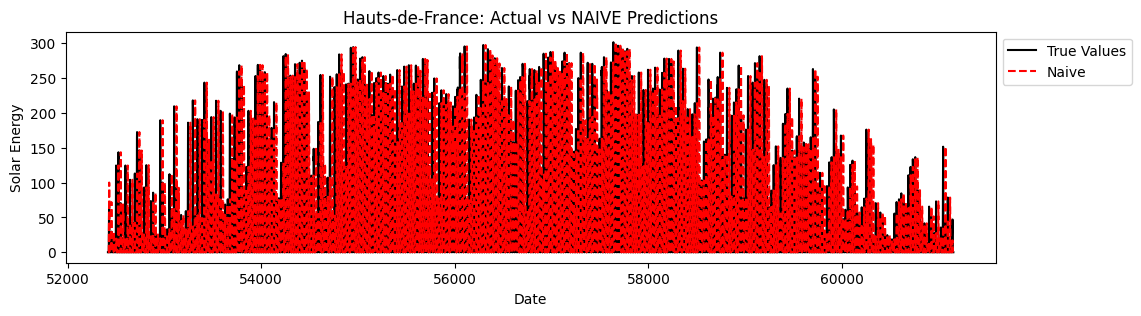

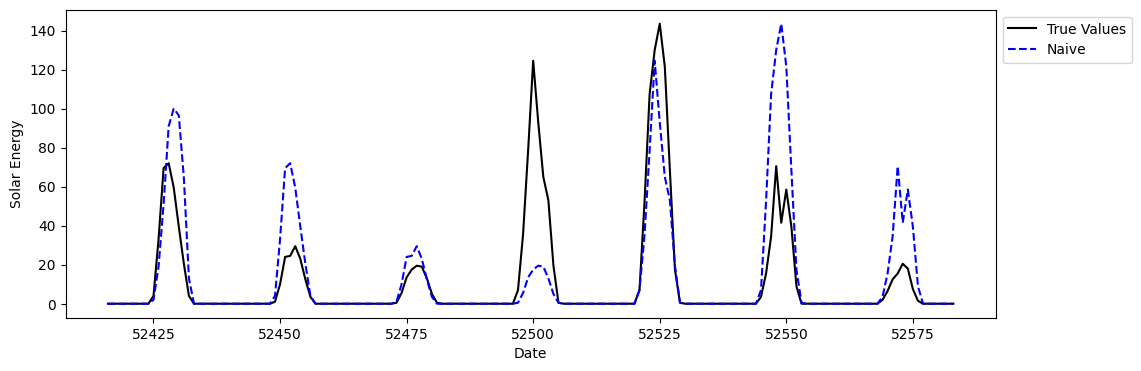

In [6]:
hdf_data = df_all_predictions[df_all_predictions['Region']=='Hauts-de-France']

evaluate_plot(hdf_data['y_true'], hdf_data['y_pred_naive'], 'Naive', 'Hauts-de-France')